In [1]:
""" Example to analyze Desroziers uncertainty from file """

import os,sys
import pandas as pd
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import h5py
from datetime import datetime
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

""" Test file """
f_conv = '/raid60/scratch/leo/scratch/converted_v7/0-20000-0-06610_CEUAS_merged_v1.nc'
f_des = '/raid60/scratch/leo/CHECK/0-20000-0-06610_CEUAS_merged_v1_uncertainty.nc'

STATION = f_conv.split('/')[-1].split('_CEUAS')[0]
station_name = 'Payerne'
#F =  h5py.File(f, 'r')

std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]

def get_data(file_conv, file_des, variables = [85, 104,105,107], split = False):
    """ Simple script to extract only the most relevant data out of a netCDF file using h5py.
    if split=True, need to read uncertainties from separate desrozier file,
    wile observations data from converted v6 files """
    
    
    f =  h5py.File(file_conv, 'r')
    if split:
        f_des = h5py.File(file_des, 'r')
    else:
        f_des = f 
    dfs = {}
    for v in variables:
        if not os.path.isfile('data/desroziers_dataframe_' + str(v) + '_pickle_' + STATION ):
            print('***** Exctracting Data for Variable: ' , v , ' ***** ')
            res = {}

            indices = f['recordindices'][str(v)]
            imin, imax = min(indices) , max(indices) # I miss here the last entr since I would need the exact index 

            ind_all = np.array([])
            for p in std_plevs:
            #for p in [1000, 2000, ]:
                a = np.where(f['observations_table']['z_coordinate'][imin:imax] == p)[0]
                ind_all = np.append(ind_all, a)


            obs_vars = ['date_time', 'observation_value', 'observed_variable', 'z_coordinate' ]
            fb_vars  = ['biascorr@body' , 'an_depar@body', 'fg_depar@body' ]

            ind_all = list(ind_all)

            print("Reading the observations data ")

            for c in obs_vars:
                res[c] = np.take(f['observations_table'][c][imin:imax], ind_all )

            for c in fb_vars:
                res[c] = np.take(f['era5fb'][c][imin:imax], ind_all )

            print("Reading the uncertainties ")
            unc_vars = f_des['advanced_uncertainty'].keys()
            for c in unc_vars:
                res[c] = np.take(f_des['advanced_uncertainty'][c][imin:imax], ind_all )


            print("--- Creating the data frame ---")
            df = pd.DataFrame.from_dict(res)
            dfs[str(v)] = df
            df.to_pickle('data/desroziers_dataframe_' + str(v) + '_pickle_' + STATION )
        else:
            print('***** Reading variable from pickle: ' , v )
            df = pd.read_pickle('data/desroziers_dataframe_' + str(v) + '_pickle_' + STATION )
            dfs[str(v)] = pd.DataFrame.from_dict(df)

    return dfs

<ipython-input-1-6b5695b3bd2b>:14: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
res = get_data(f_conv, f_des, variables = [34,36,38,85,104,105,107], split = True) # dictionary of dataframes 

OSError: Unable to open file (unable to open file: name = '/raid60/scratch/leo/scratch/converted_v7/0-20000-0-06610_CEUAS_merged_v1.nc', errno = 13, error message = 'Permission denied', flags = 0, o_flags = 0)

In [4]:
#res['85'].to_pickle('data/desroziers_dataframe_85_pickle_' + STATION)
#res['36'].to_pickle('data/desroziers_dataframe_36_pickle_' + STATION)
#res['38'].to_pickle('data/desroziers_dataframe_38_pickle_' + STATION)
#res['105'].to_pickle('data/desroziers_dataframe_105_' + STATION)
#res['107'].to_pickle('data/desroziers_dataframe_107_' + STATION)


In [5]:
# Common for all plots 
dic = { 85 : {'x':'Temperature [K]'       , 'y': 'Pressure [hPa]' , 'ylim': (180,340), 'ylimdes': (0,10) } ,
            #106 : {'x': 'Wind from Direction'  , 'y': 'Pressure [hPa]', 'ylim': (180,340), 'ylimdes': (0,14) },
        107 : {'x': 'Wind Speed [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (0,100), 'ylimdes': (0,30) },
         
        104 : {'x': 'Wind u-component [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (-50,100), 'ylimdes': (0,30) },
        105 : {'x': 'Wind v-component [m/s] '    , 'y': 'Pressure [hPa]', 'ylim': (-50,100), 'ylimdes': (0,30) },

        34 : {'x': 'Dew Point Depr. [K] '    , 'y': 'Pressure [hPa]', 'ylim': (-5,60), 'ylimdes': (0,30) },
        36 : {'x': 'Dew Point Temp. [K]  '    , 'y': 'Pressure [hPa]', 'ylim': (180,340), 'ylimdes': (0,30) },
        38 : {'x': 'Relative Humidity '       , 'y': 'Pressure [hPa]', 'ylim': (-1.5,1.5), 'ylimdes': (0,1.5) },
        39 : {'x': 'Specific Humidity '      , 'y': 'Pressure [hPa]', 'ylim': (0,0.01), 'ylimdes': (0,0.001) },

          }


In [6]:
def remove_outliers(data= '', min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True):
        """ Finds outliers, and replace them with np.nan (to keep vector of same length)                                                                                                                                                                                              

             input ::       data = list of values 
                               min_p , max_p = minimum and maximum values of the percentile to consider to determine outliers 
                               skewed = use True to consider a skewed (not symmetricla Gaussian) distribution 
                               cut = factor to allow slight deviation from given percentiles 
             returns ::   cleaned   = list of values without outliers                                                                                                                                                                    
                               outliers   = list of outlier values                                                                                                                                                                                                               
                               lower,upper, median = outliers delimiter and median values.
            if only_clean == True, return only list of cleaned values. """
        
        q_min, q_max = np.nanpercentile(data, min_p), np.nanpercentile(data, max_p)
        cut_off = (q_max - q_min) * cut
        lower, upper = q_min-cut_off, q_max+cut_off

        if skewed==True:
            q50 = np.nanpercentile(data, 50)
            lower , upper = q_min-(q50-q_min)*cut ,  q_max+(q_max-q50)*cut  # the higher the cut, the more relaxed the contition for exclusion 

        median = np.nanmedian(data)
        cleaned, outliers = [],[]

        indices = []
        for d,ind in zip(np.asarray(data), range(len(data))):
            if d >= lower and d <= upper:
                cleaned.append(d)
                indices.append(ind)
                         
            else: # only storing non nans values 
                if not np.isnan(d):
                    outliers.append(d)

        if only_clean:
            return cleaned, indices
        else:

            return cleaned, indices, outliers, lower, upper, median

In [7]:
#""" Selecting a date """
#DATE = '1986-08-24T12:00:00'
#dt = np.datetime64(DATE)
#DF_t = DF.loc[ (DF['date_time'] == dt) ]
#a= DF.loc[ DF['observed_variable'] == 107 ][['date_time','desroziers_30','z_coordinate','num_30','observation_value']]
#print(a )
#plt.plot(DF['date_time'], DF['desroziers_30'])
#plt.show()

In [8]:
def plot(df_in= '', station='', vars = [], what = 'des', zoom = False, which_plot = 'series'):
    if not os.path.isdir('Plots'):
        os.mkdir('Plots')
    import matplotlib.gridspec as gridspec
    #plt.plot(DF['date_time'], DF['desroziers_30'])
    text = ''
    fs = 15 # fontsize
    
    STATION = station 
    
    for v in vars:
        
        df = df_in[str(v)]
        #print(df_in)
        fig = plt.figure(figsize=(15,15), constrained_layout=True)
        spec = gridspec.GridSpec(ncols=4, nrows=4)

        #df = df_in.loc[ df_in['observed_variable'] == v ]

        axs = []
        for p,num in zip(std_plevs , range(1,17) ):
            a= df.loc[ df['z_coordinate'] == p ]
            #print(a.head(n=5))
            x   = a['date_time']
            x = np.array(x)/(3600*24*365.25) + 1900
            obs = a['observation_value']
            y30 = a['desroziers_30']
            y90 = a['desroziers_90']
            y60 = a['desroziers_60']
            y180 = a['desroziers_180']
            num_30 = a['num_30']
            num_180 = a['num_180']
            num_60 = a['num_60']
            num_90 = a['num_90']
            
            an = a['an_depar@body']
            fg = a['fg_depar@body']
   
            var = a['observed_variable']
            print(v , ' unique values:  ' , np.unique(var))

            if which_plot == 'series':
                fig.suptitle('Timeseries for ' + dic[v]['x'] + ' - Station ' + station, y = 0.93, fontsize = 20 )

                axs.append(fig.add_subplot(spec[num -1]) )
                ax = axs[-1]
            
                ax.set_title( '[' + str(p) + ' hPa]' )

                OBS, indices = remove_outliers(data= obs, min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True)
                X = x[indices]
                ax.plot(X,OBS, label = 'Obs', color = 'lightgray')

                if num ==1:
                    ax.legend(fontsize = 9)
                #ax.grid(ls=':' , color = 'lightgray')
                #ax.set_xticks([])
                if num not in [1,5,9,13]:
                    ax.set_yticks([])
                
                ax.tick_params(axis='x', rotation=45)

                ax2=ax.twinx()
                if what == 'des':
                    ax2.plot(x,y30,  color = 'orange'    , label = 'Des. 30'  )
                    ax2.plot(x,y90,  color = 'lime'      , label = 'Des. 90'  )
                    ax2.plot(x,y180, color = 'slateblue' , label = 'Des. 180' )
                    ax2.set_ylim(dic[v]['ylimdes'])
                else:
                    ax2.plot(x,an, color = 'red', label = 'Analysis Dep.'   )
                    ax2.plot(x,fg, color = 'blue', label = 'Background Dep.' )
           
                    if v in [38]:
                         ax2.set_ylim((-1.5,1.5))
                    else:
                        ax2.set_ylim((-50,50))

                if num ==1:
                    ax2.legend(fontsize = 9, loc = 'upper right')
                    ax.legend(fontsize = 9, loc = 'upper left')
                    
                if num not in [4,8,12,16]:
                    ax2.set_yticks([])
                if num in  [4,8,12,16]:
                    if what == 'des':
                        ax2.set_ylabel('Uncertainty', fontsize = fs)
                    else:
                        ax2.set_ylabel('Departure', fontsize = fs)

                if num in [1,5,9,13]:
                    ax.set_ylabel('Observations', fontsize = fs)

                if num <= 12:
                    ax2.set_xticks([])
                ax2.set_xlim(1950,2020 ) #todo
                ax2.set_xlim(1900,2020 ) #todo

                
                if zoom:
                    ax2.set_xlim(1980, 2000)
                    text = 'zoom'
                ax.set_ylim(dic[v]['ylim'])
                
            # Plotting the number of available desr entries used for ethe time window average 
            elif which_plot == 'num':
                fig.suptitle('Number of records available for ' + dic[v]['x'] + ' - Station ' + station, y = 0.93, fontsize = 20 )

                axs.append(fig.add_subplot(spec[num -1]) )
                ax = axs[-1]
            
                ax.set_title( '[' + str(p) + ' hPa]' )

                OBS, indices = remove_outliers(data= obs, min_p= 25, max_p= 75, cut= 1, skewed= False, only_clean = True)
                X = x[indices]
                ax.scatter(x,num_30 , label = 'Records 30 days', color = 'orange'    , s=0.8 )
                ax.scatter(x,num_60 , label = 'Records 60 days', color = 'red'       , s=0.8 )
                ax.scatter(x,num_90 , label = 'Records 90 days', color = 'lime'      , s=0.8 )
                ax.scatter(x,num_180, label = 'Records 180 days', color = 'slateblue', s=0.8 )

                if num ==1:
                    ax.legend(fontsize = 9)
                #ax.grid(ls=':' , color = 'lightgray')
                #ax.set_xticks([])
                if num not in [1,5,9,13]:
                    ax.set_yticks([])
                
                ax.tick_params(axis='x', rotation=45)

                if num ==1:
                    ax.legend(fontsize = 9, loc = 'upper left')
                    
                if num <= 12:
                    ax.set_xticks([])


                if num in [1,5,9,13]:
                    ax.set_ylabel('Number of Records', fontsize = fs)


                #ax.set_xlim(1950,2020 ) #todo
                ax.set_xlim(1900,2020 ) #todo

                
                if zoom:
                    ax.set_xlim(1980, 2000)
                    text = 'zoom'
                ax.set_ylim(0,180)
                
            elif (which_plot == 'histo'):
                fig.suptitle('Desroziers Uncertainty for ' + dic[v]['x'] + ' - Station ' + station, y = 0.93, fontsize = 15 )

                axs.append(fig.add_subplot(spec[num -1]) )
                ax = axs[-1]
                ax.set_title( '[' + str(p) + ' hPa]' )
                data = [y30, y60, y90, y180]
                #colors = ['blue','red','gold','cyan']
                colors = ['yellow','red','green','blue']
                
                colors = ['blue','red','yellow','lime']
                #colors = ['yellow','red','blue','lime']

                if v == 85:
                    bins = np.linspace(0., 4., 50)
                elif v in [104,105,107]:
                    bins = np.linspace(0., 5., 50)
                elif v == 38:
                    bins = np.linspace(0., 0.5, 50)
                   
                labels = ['Des. 30', 'Des. 60', 'Des. 90', 'Des. 180']
                plt.hist(data, bins = bins, histtype = 'step', color = colors , alpha = 1, label = labels)
                #plt.hist(data, bins = bins, histtype = 'stepfilled' , alpha = 0.5, label = labels)
                
                ax.grid(ls=':' , color = 'lightgray')
                
                if num in [1,5,9,13]:
                    ax.set_ylabel('Counts', fontsize = fs )

                if num ==1:
                    ax.legend(fontsize = 9)
                #ax.set_xticks([])
                if num not in [1,5,9,13]:
                    ax.set_yticks([])


                #ax.set_ylim([0, 10000])
                if v == 85:
                    ax.set_xlim([0,3])
                    ax.set_ylim([0,10000])

                elif v in [104,105,107]:
                    ax.set_xlim([0,5])
                    ax.set_ylim([0,10000])

                elif v == 38:
                    ax.set_xlim([0,0.5])
                    ax.set_ylim([0,3000])


        if not os.path.isdir('Plots/desroziers'):
            os.system('mkdir Plots/desroziers')
        if not os.path.isdir('Plots/desroziers/' + STATION):
            os.system('mkdir Plots/desroziers/' + STATION)
            
        plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
        plt.show()
        plt.close()
            
        
            
            
 

In [9]:
variables = [36, 38, 85,104,105,107]
variables = [36, 38, 85, 107]

36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


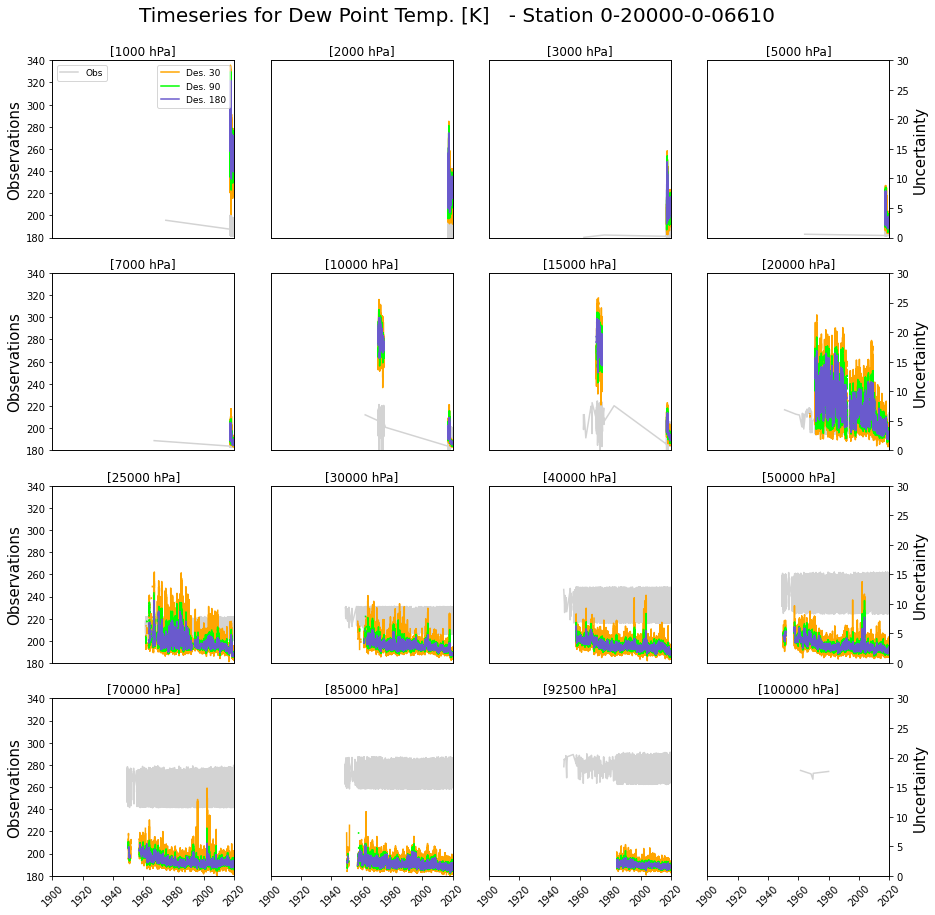

38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


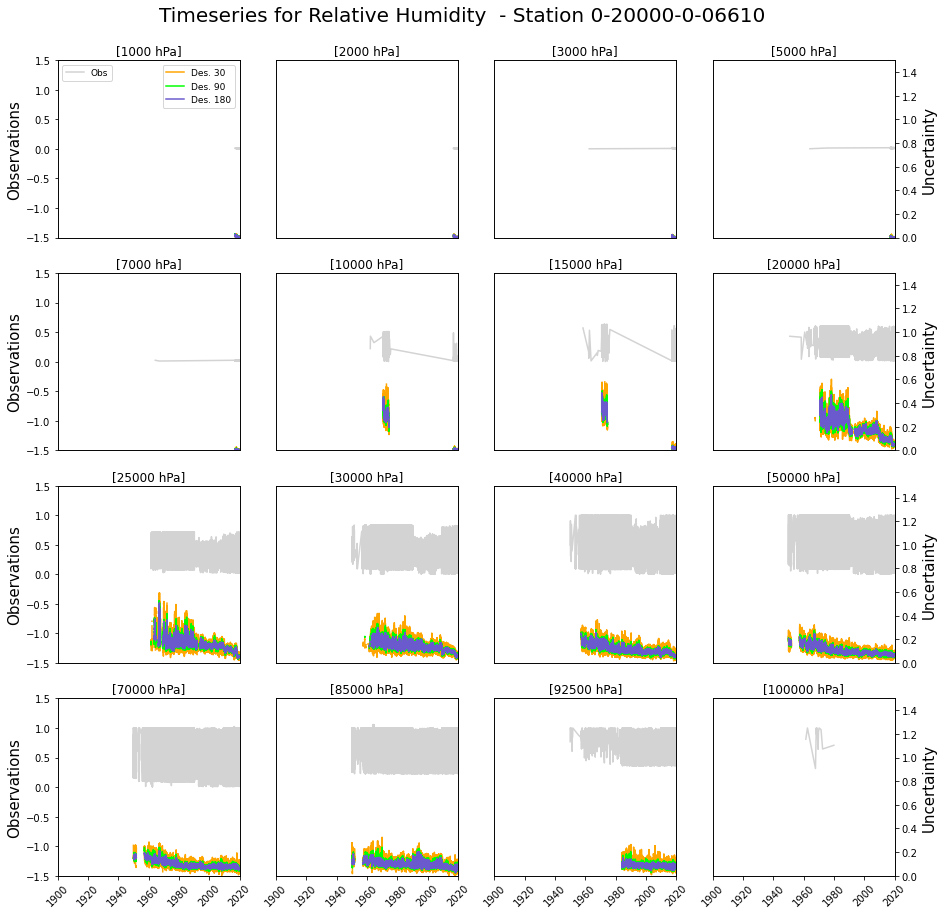

85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


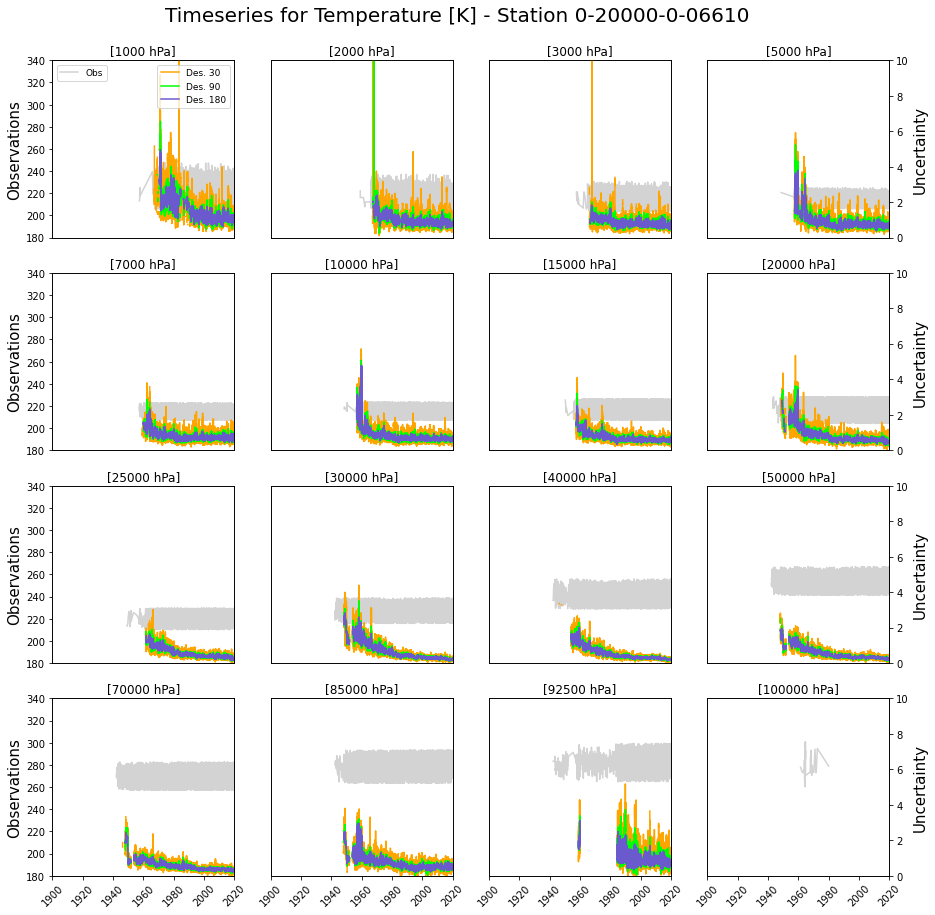

107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


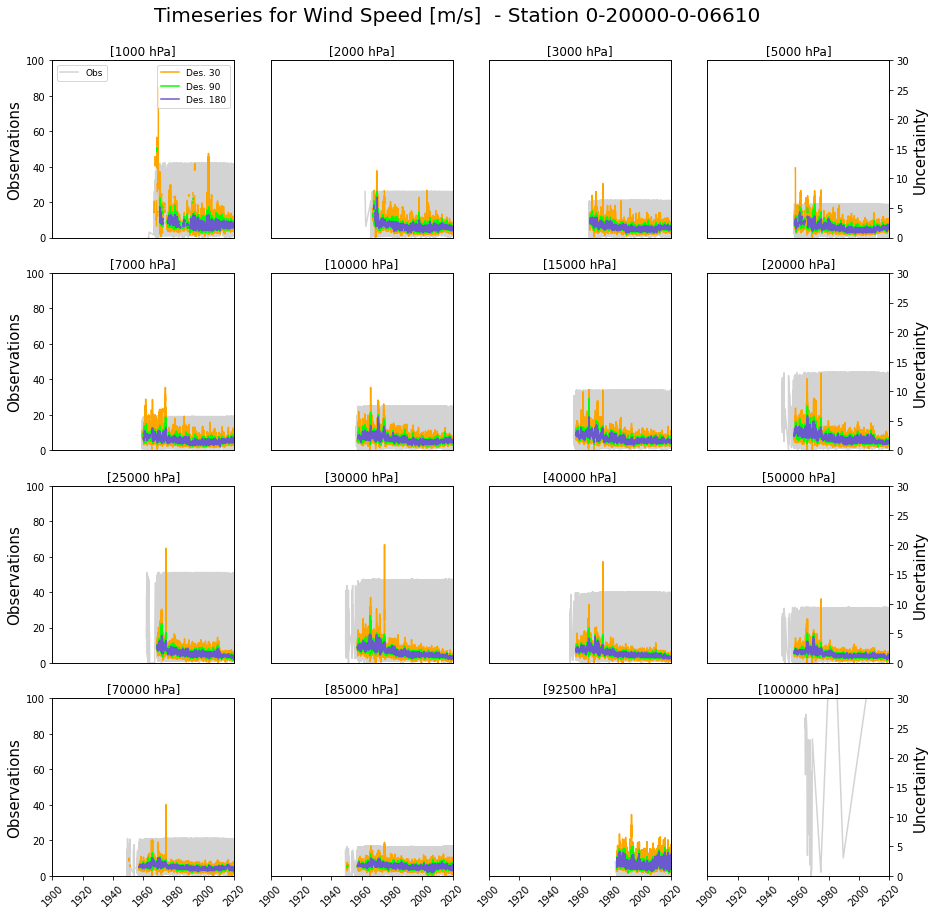

In [10]:
series = plot(df_in=res, station=STATION, vars = variables )

36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


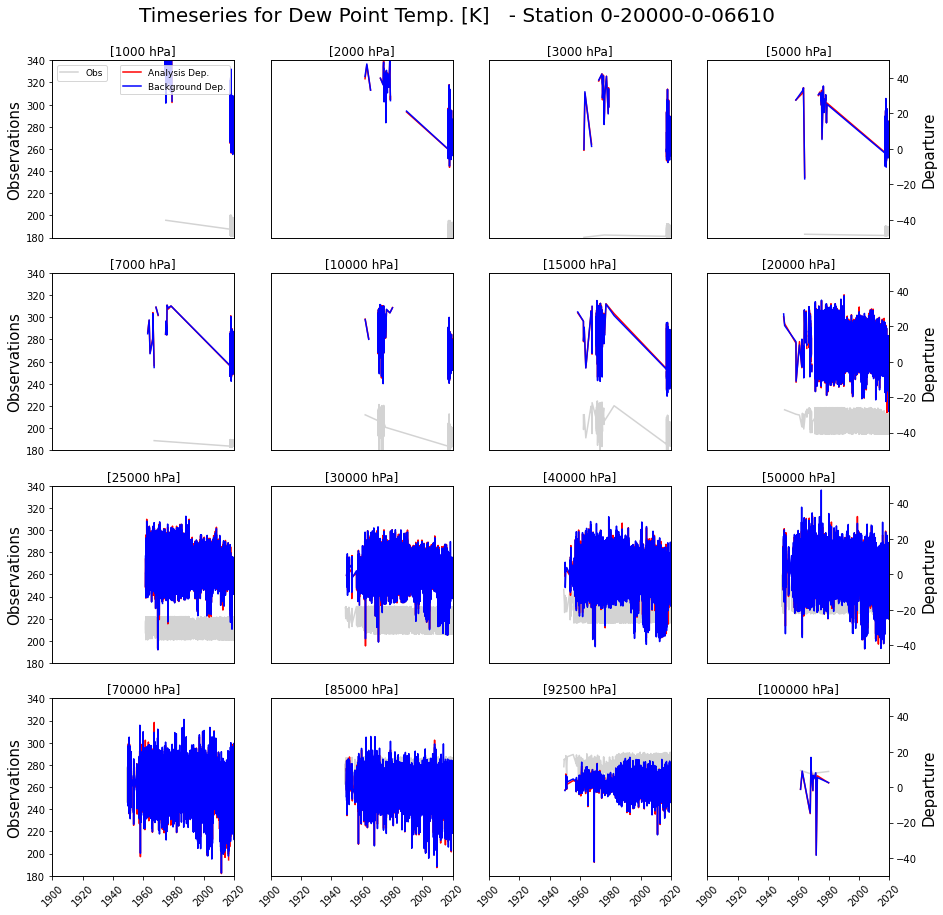

38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


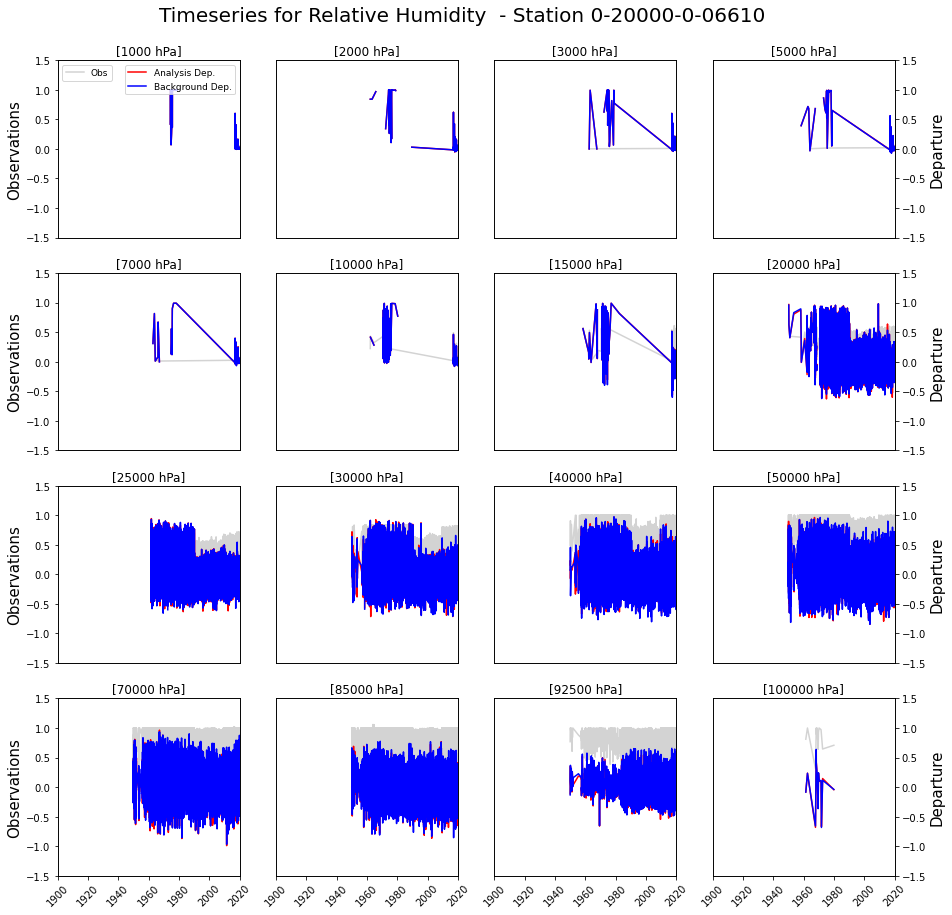

85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


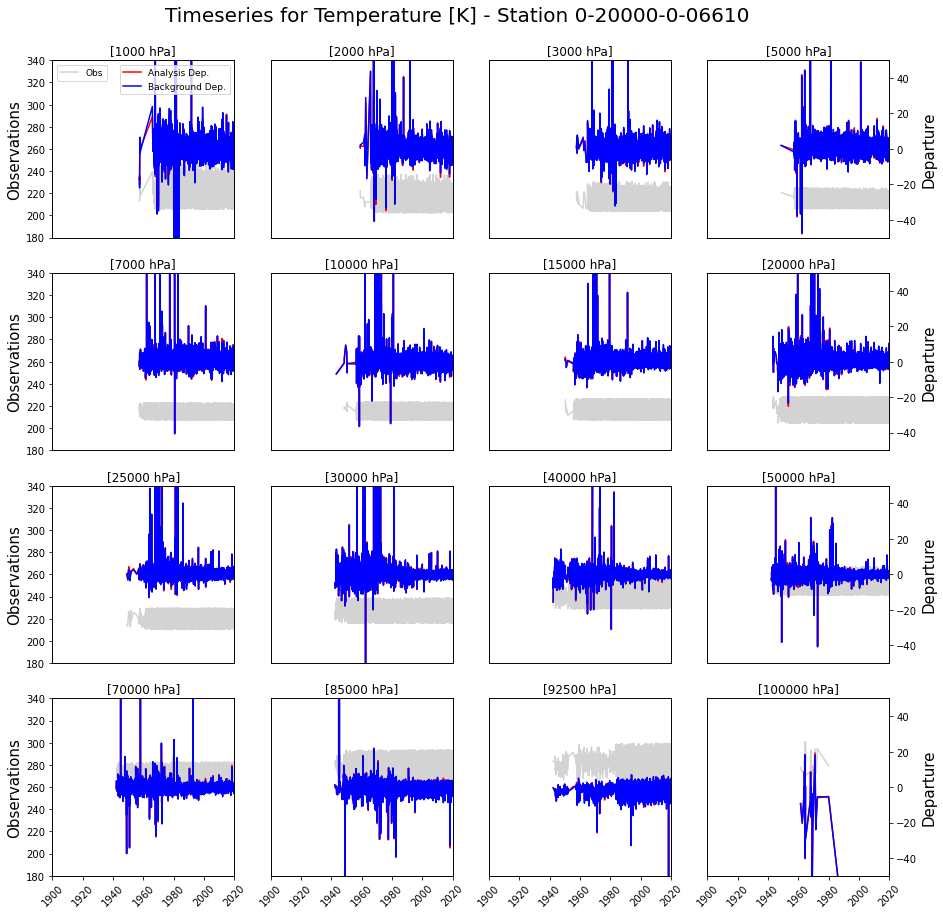

107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


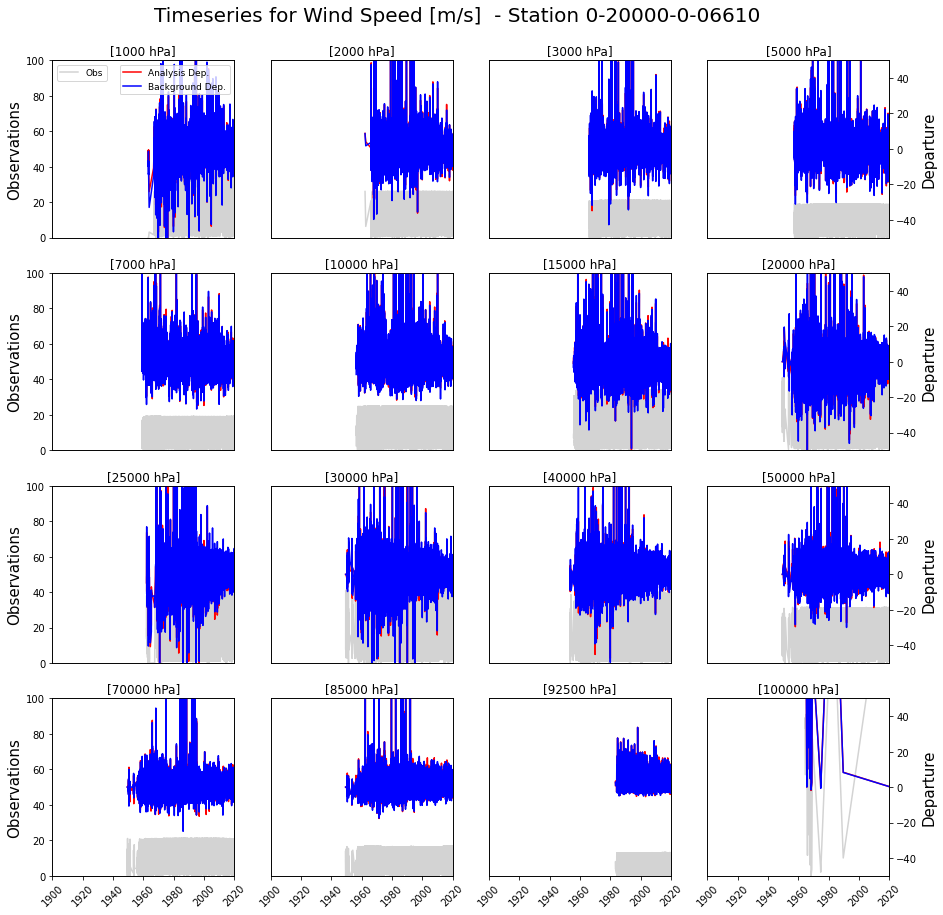

In [11]:
series = plot(df_in=res, station=STATION, vars = variables, what = 'dep' )

36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]
36  unique values:   [36]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


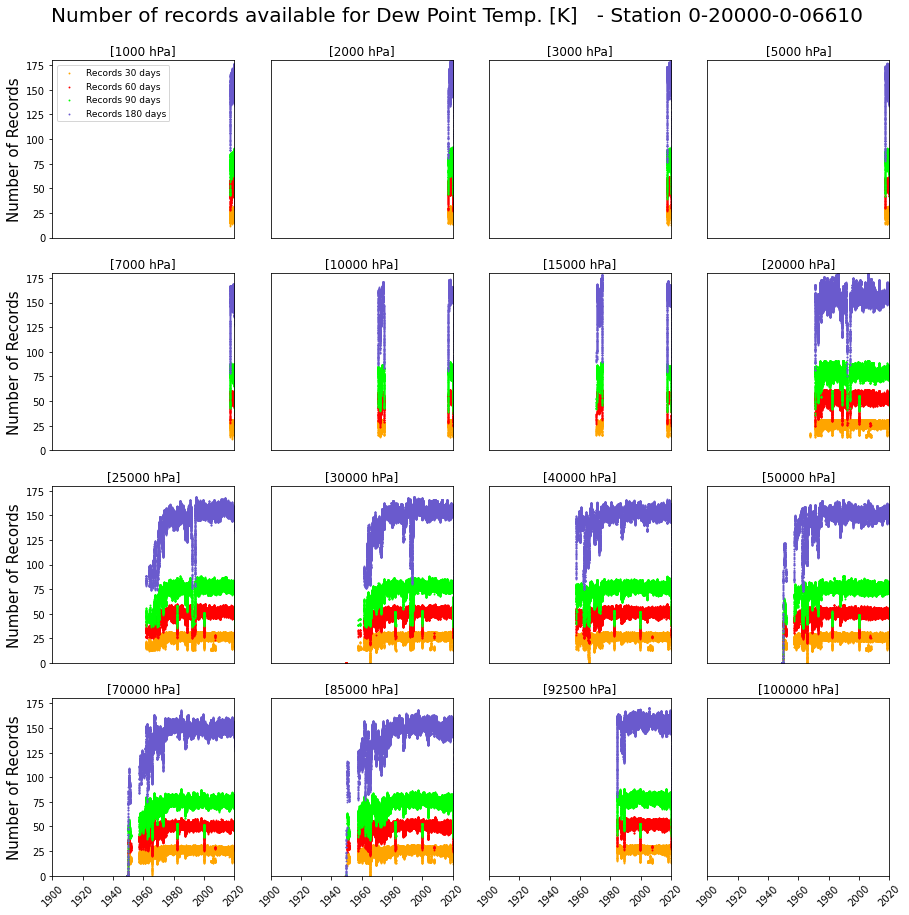

38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


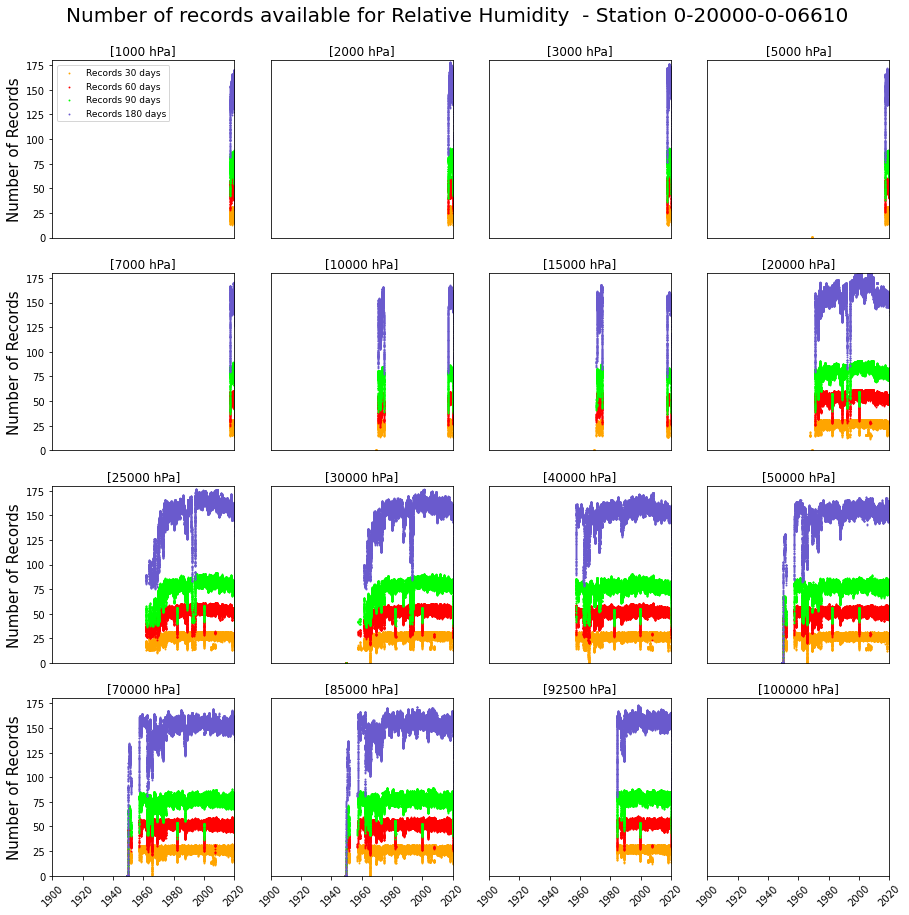

85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


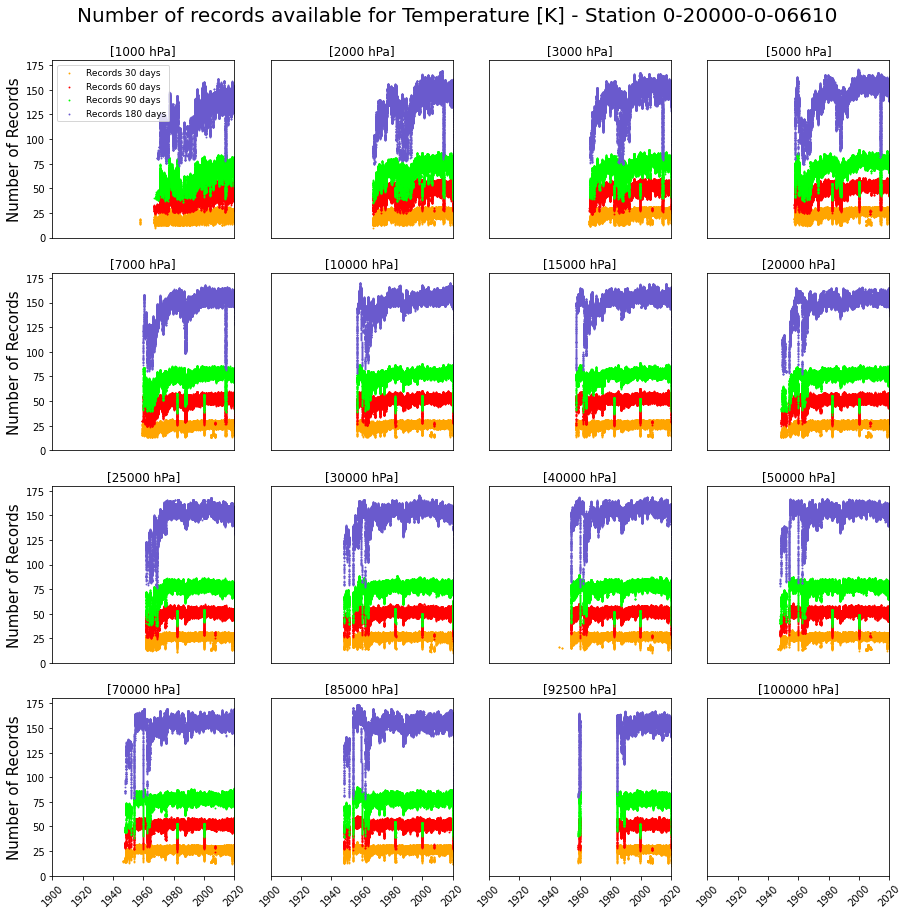

107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


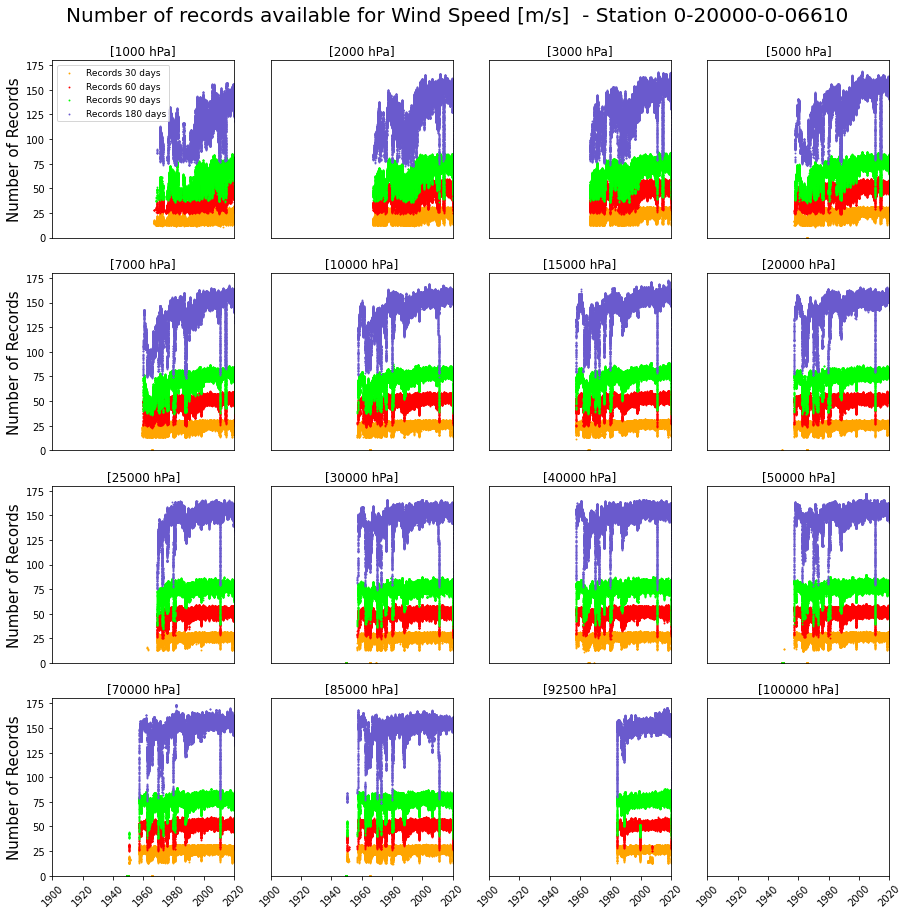

In [12]:
series = plot(df_in=res, station=STATION, vars = variables, what = 'num', which_plot = 'num' )

38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


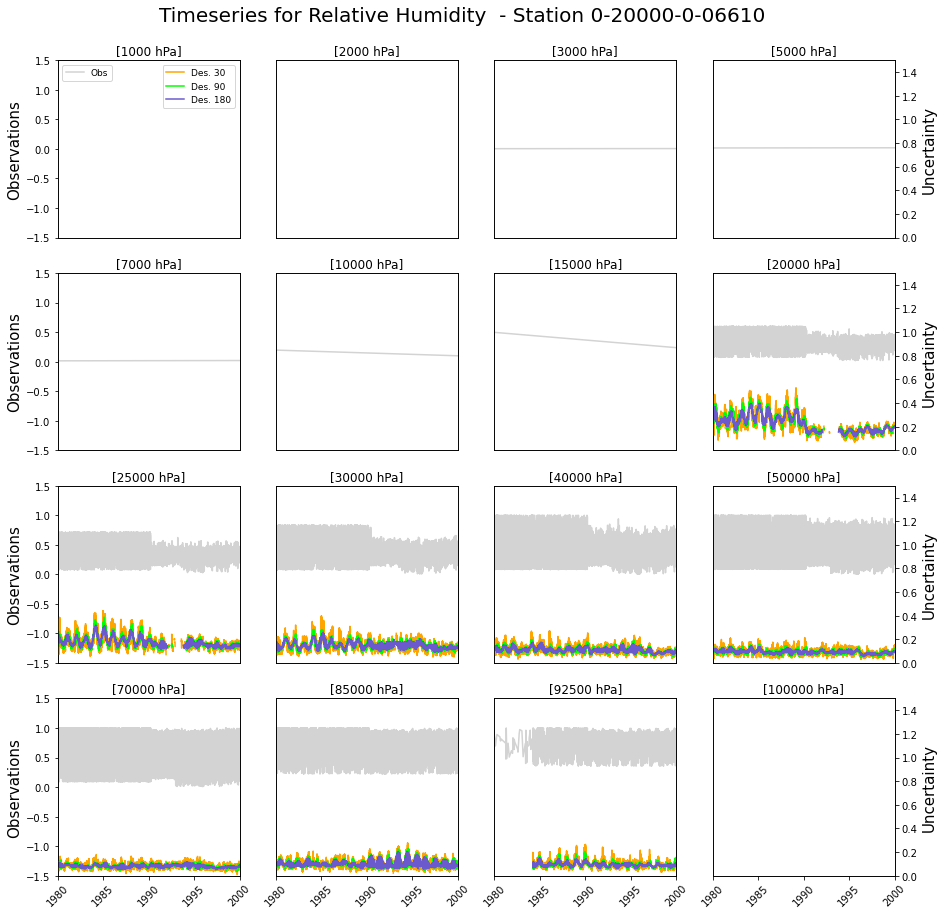

85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


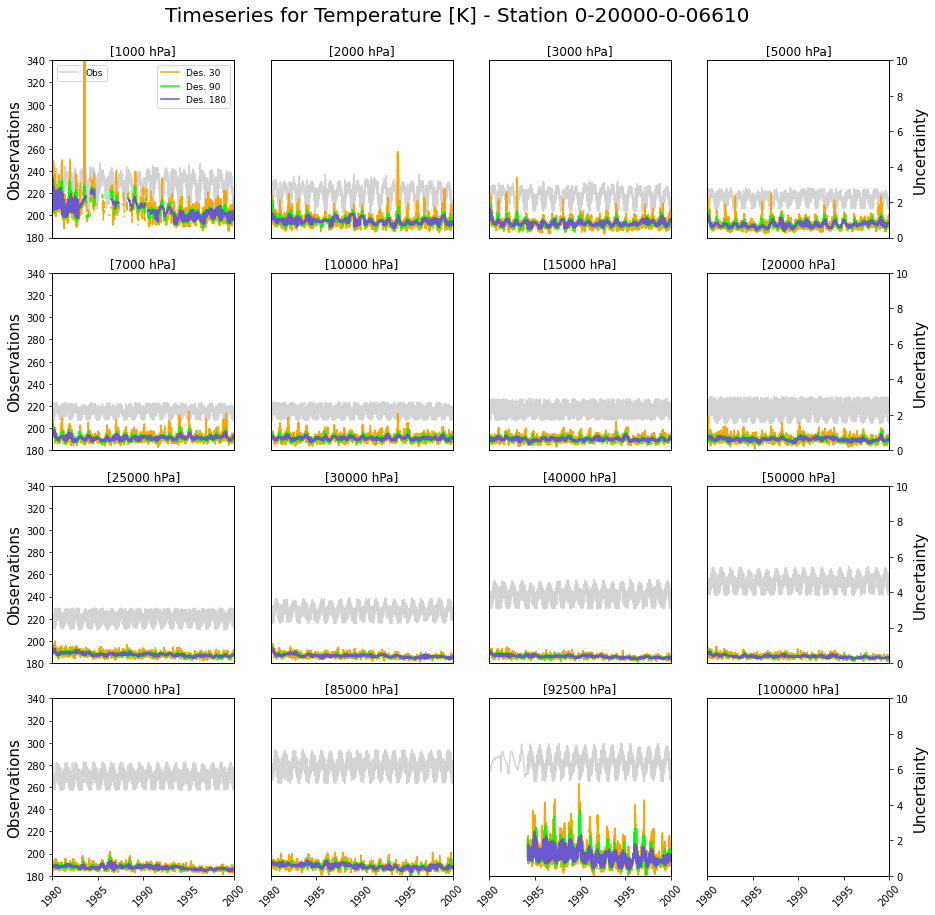

104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


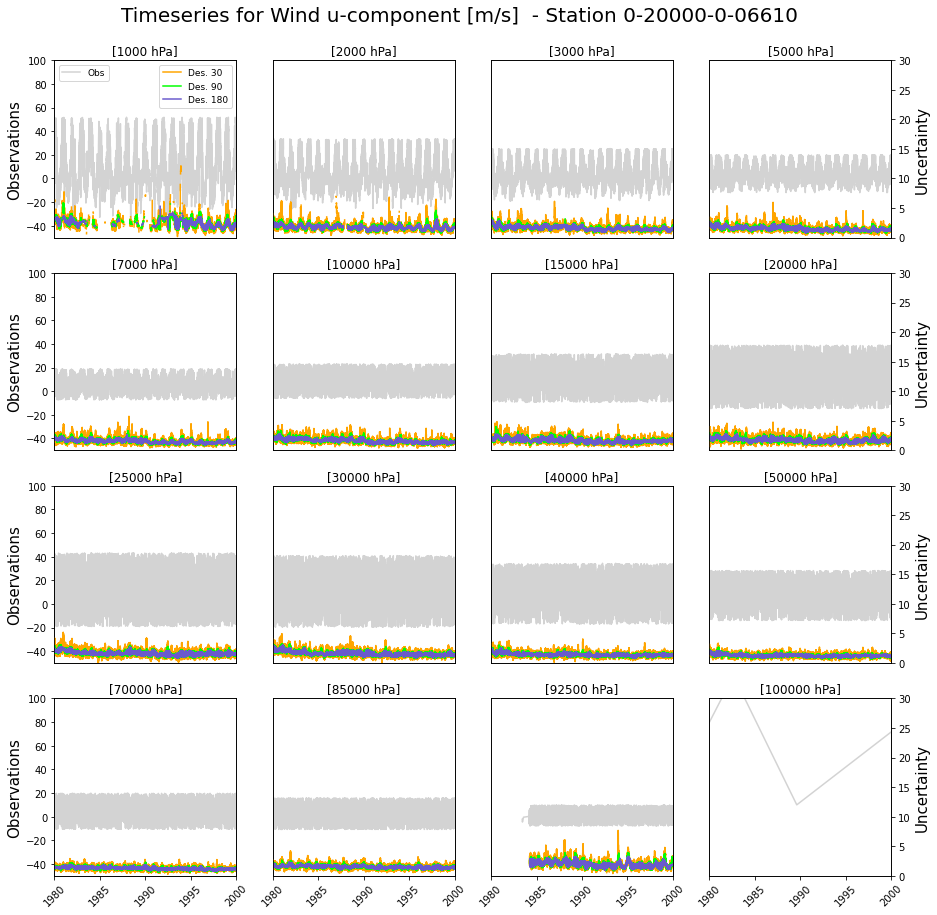

105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


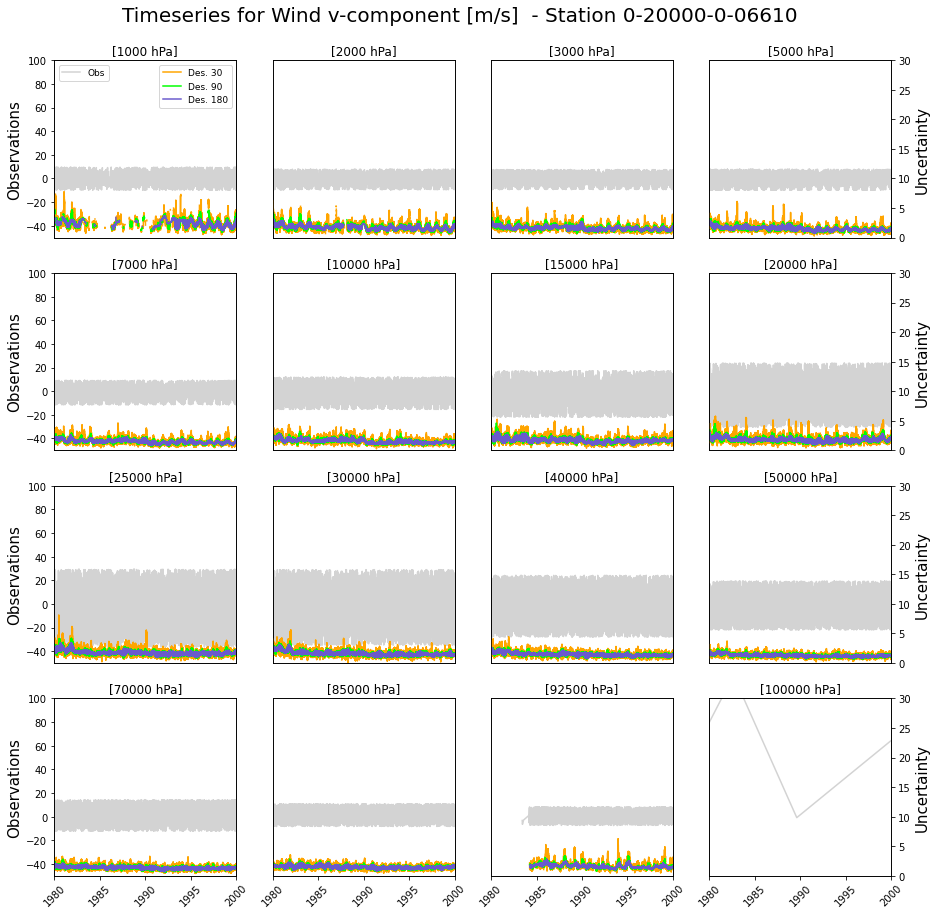

107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


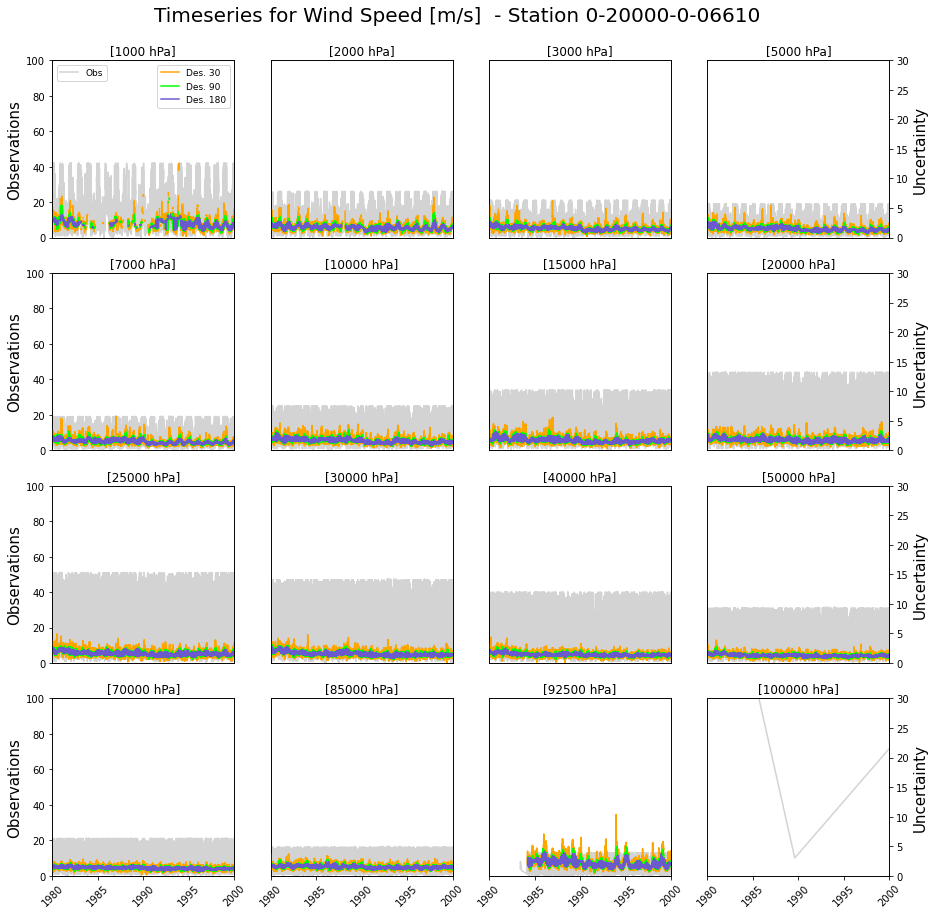

In [13]:
variables = [38,85,104,105,107]
series = plot(df_in=res, station=STATION, vars = variables, zoom = True  )

38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


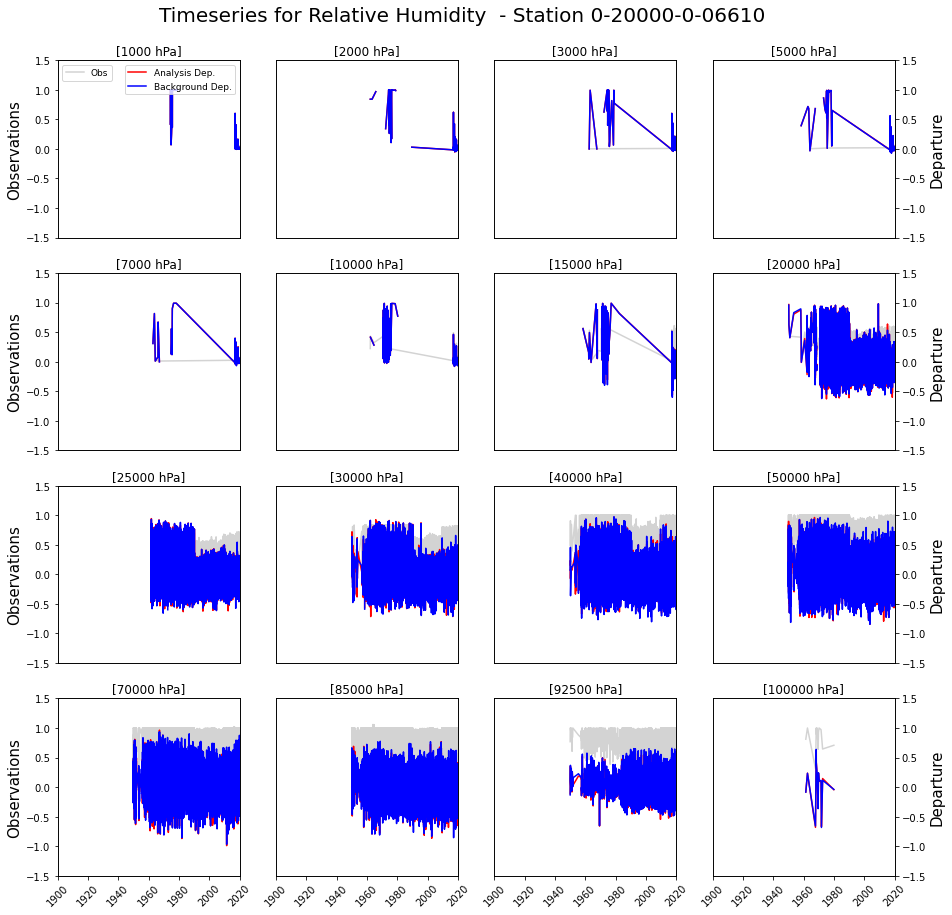

85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


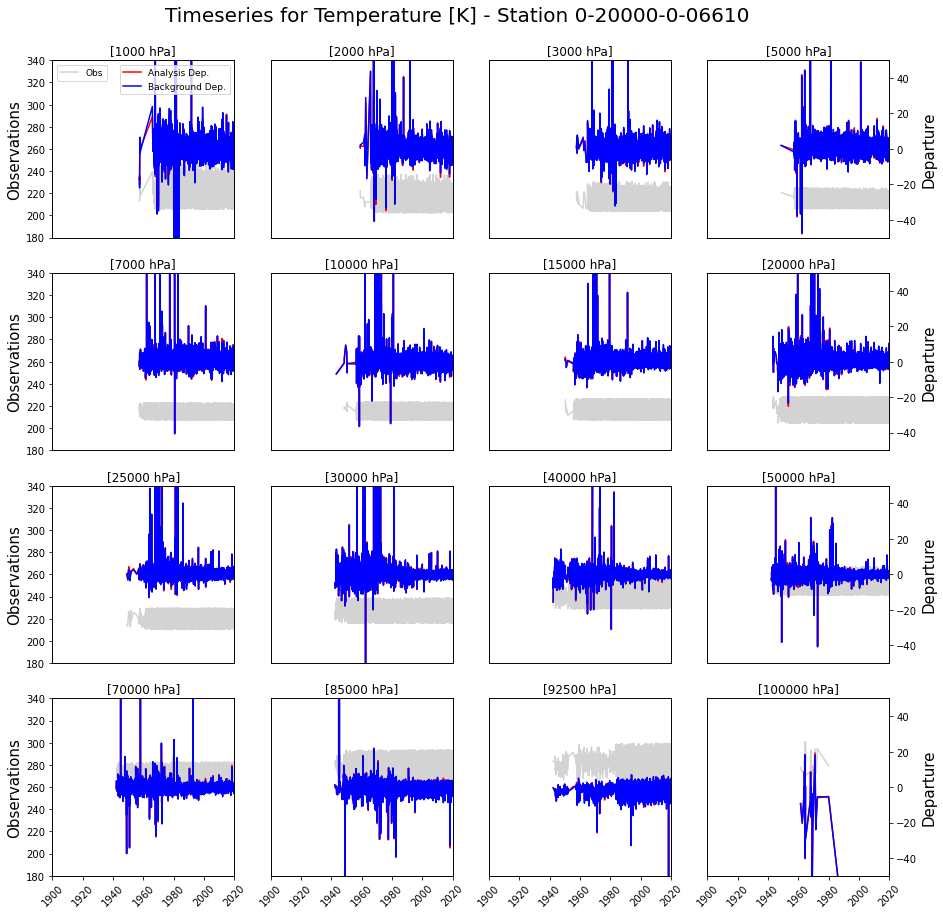

104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


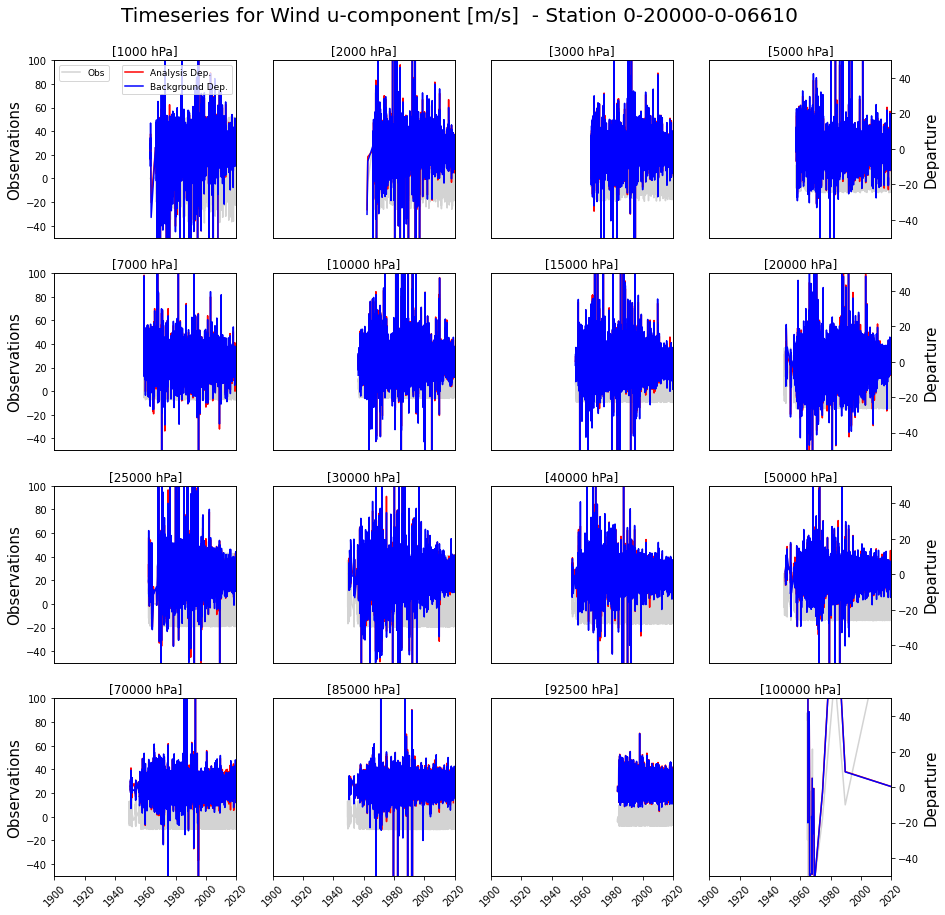

105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


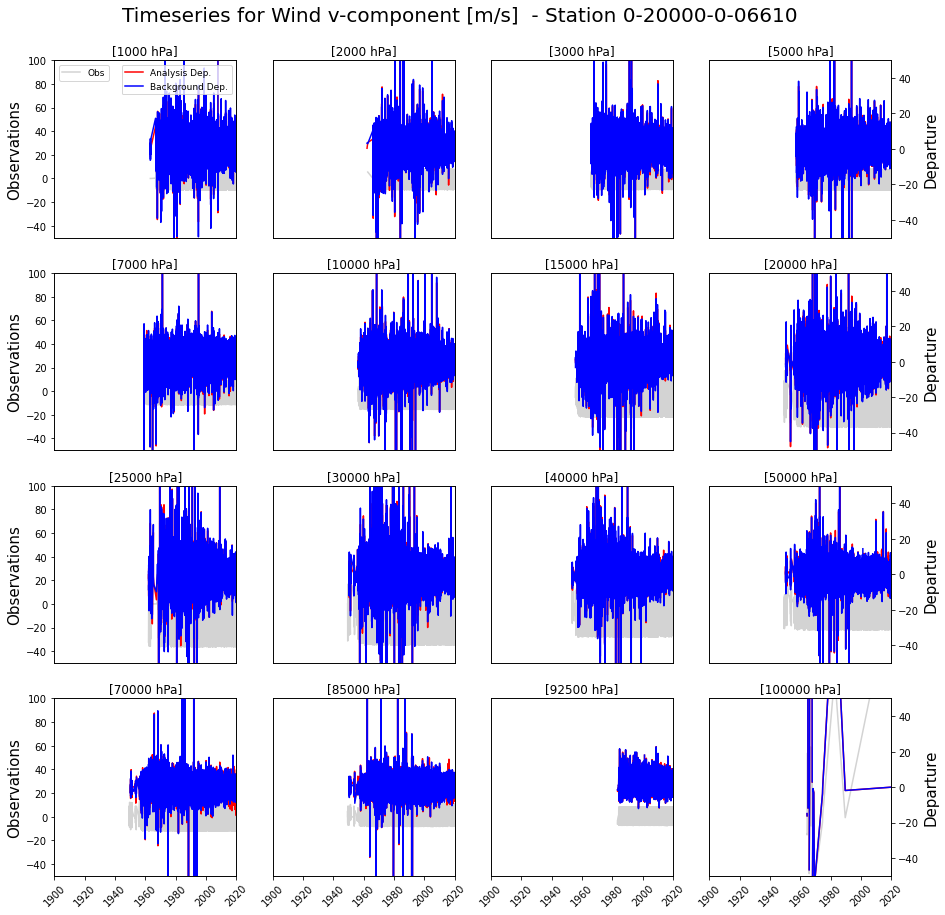

107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


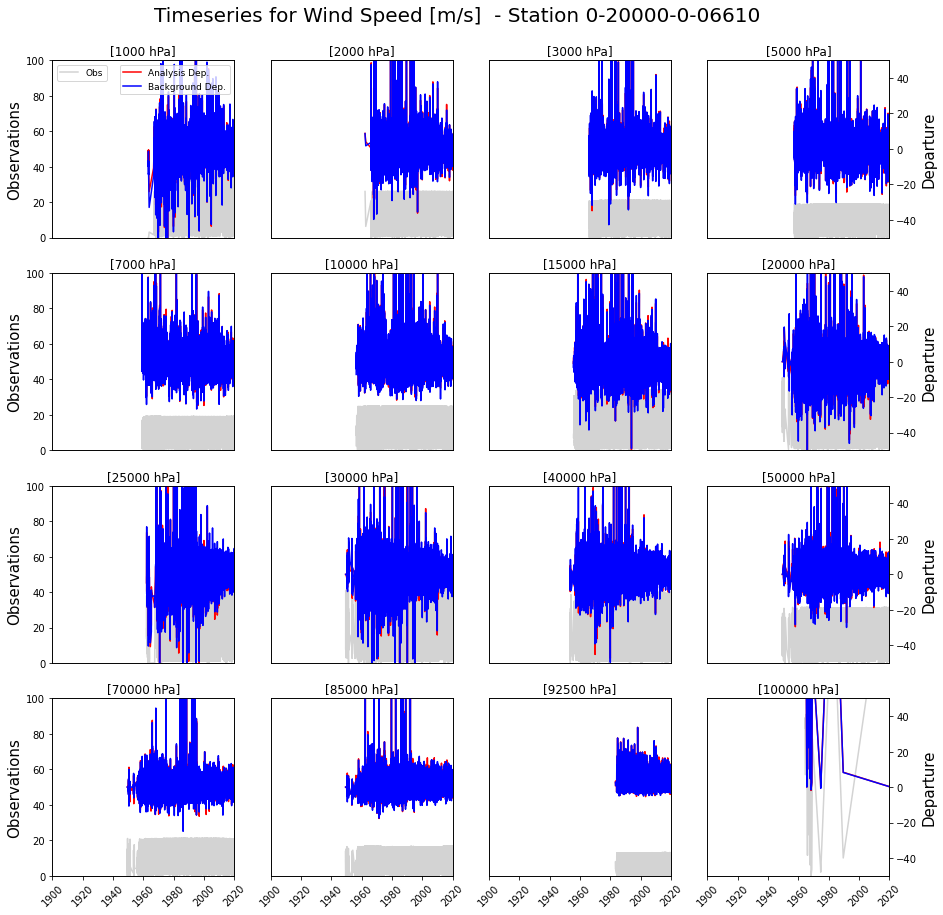

In [14]:
series = plot(df_in=res, station=STATION, vars = variables, what = 'dep' )

38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


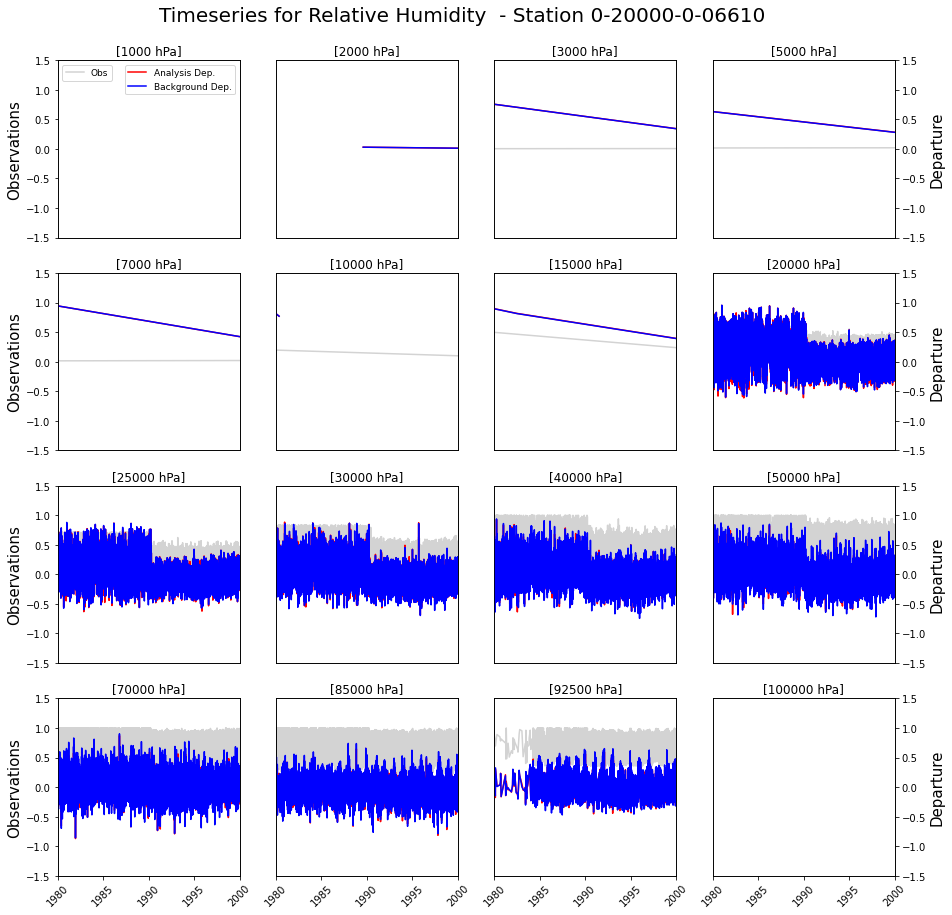

85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


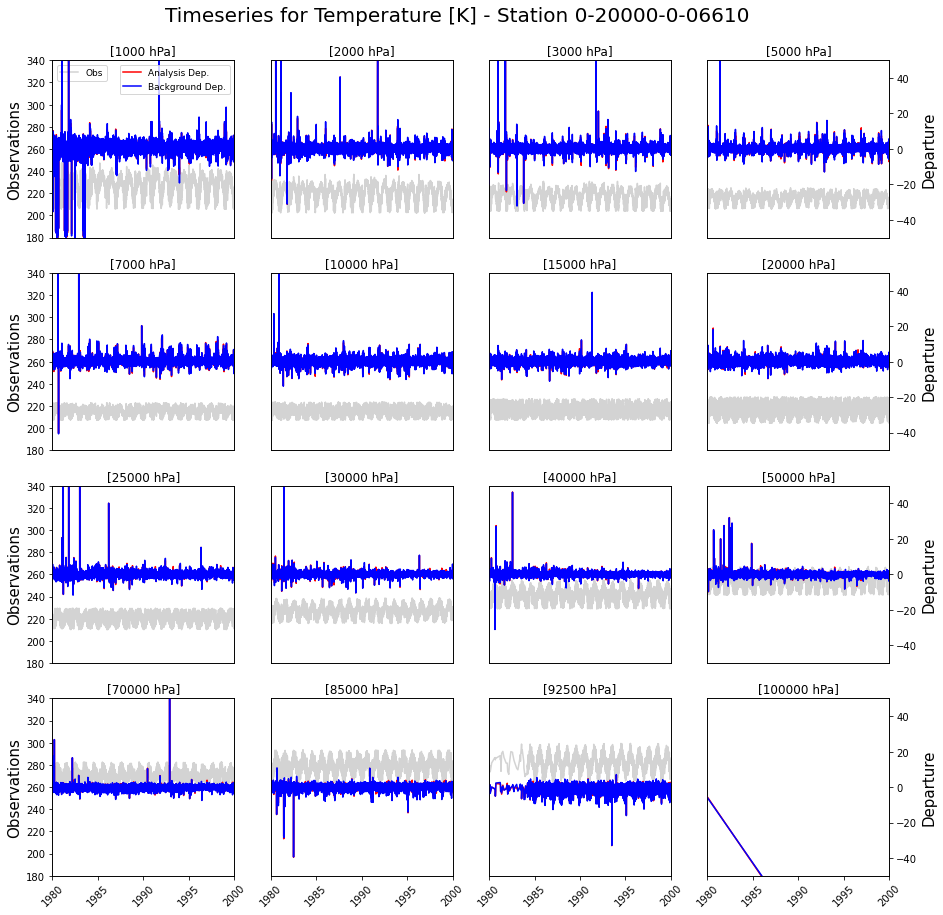

104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


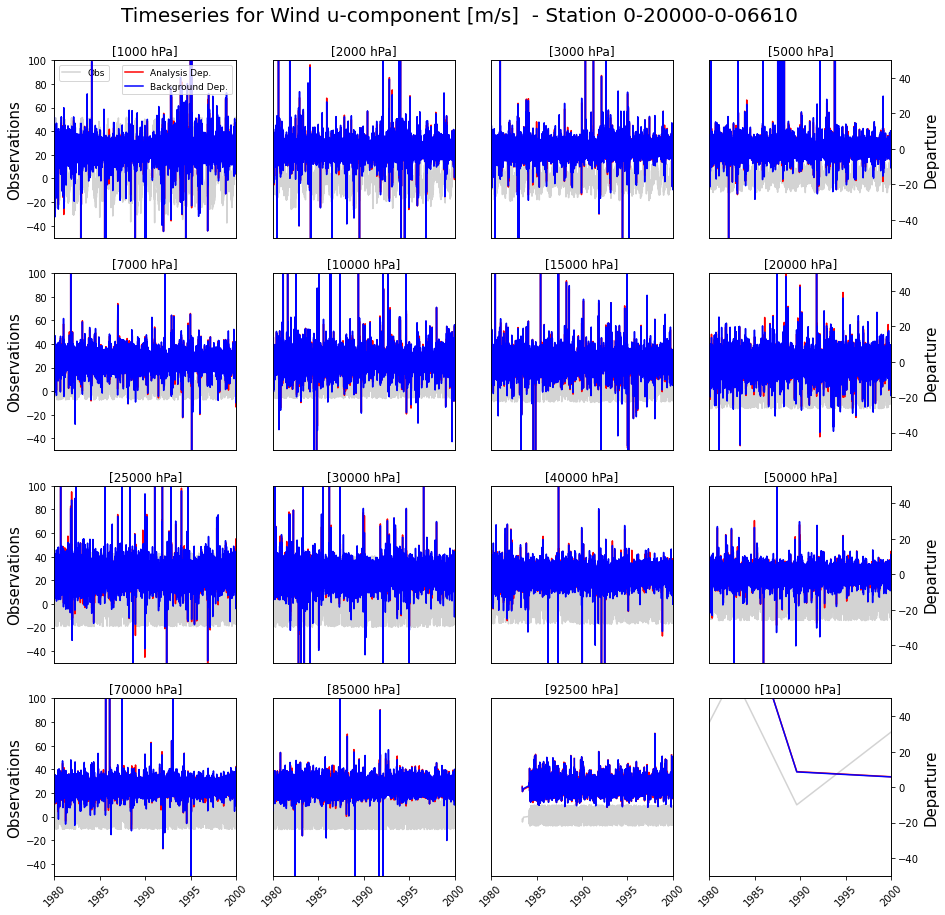

105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


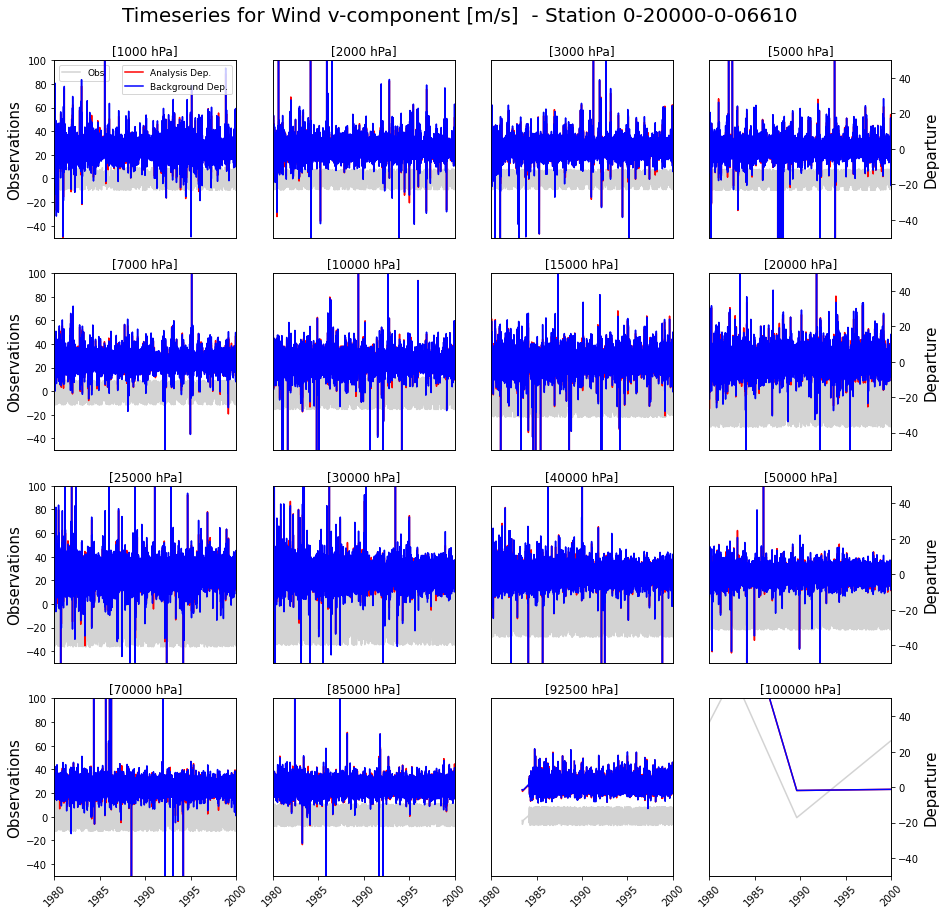

107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]


<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  fig.canvas.print_figure(bytes_io, **kw)


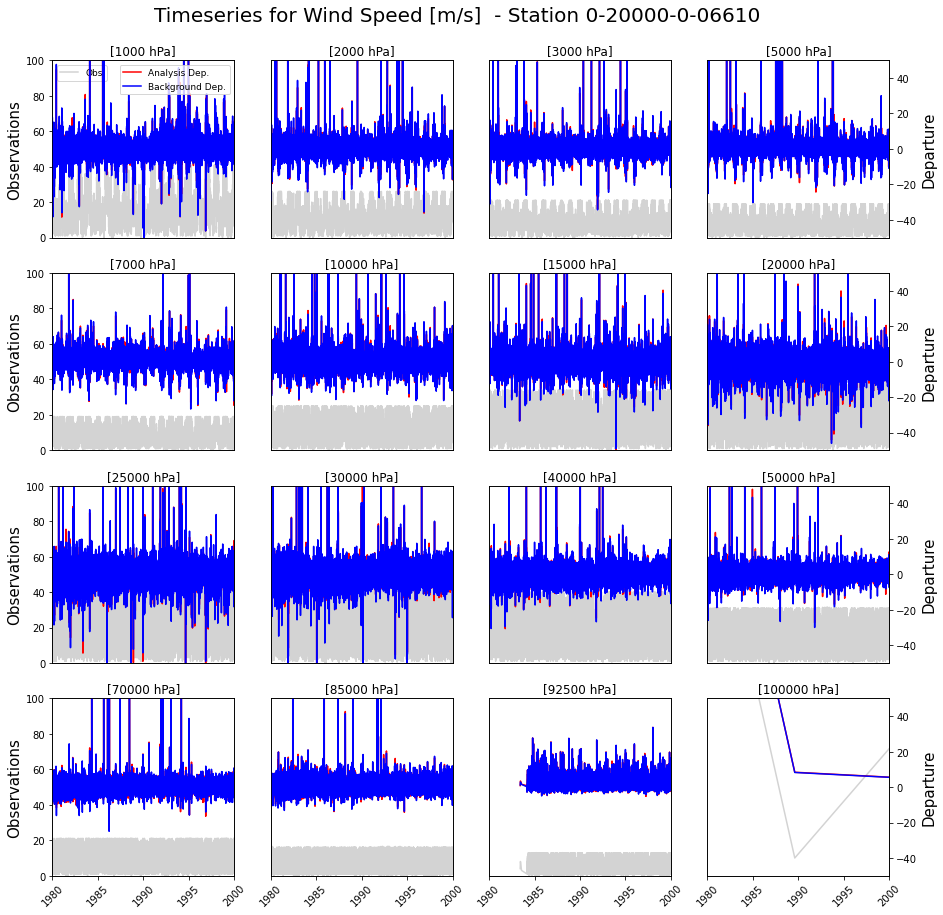

In [15]:
series = plot(df_in=res, station=STATION, vars = variables, what = 'dep', zoom = True  )

38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]
38  unique values:   [38]


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you 

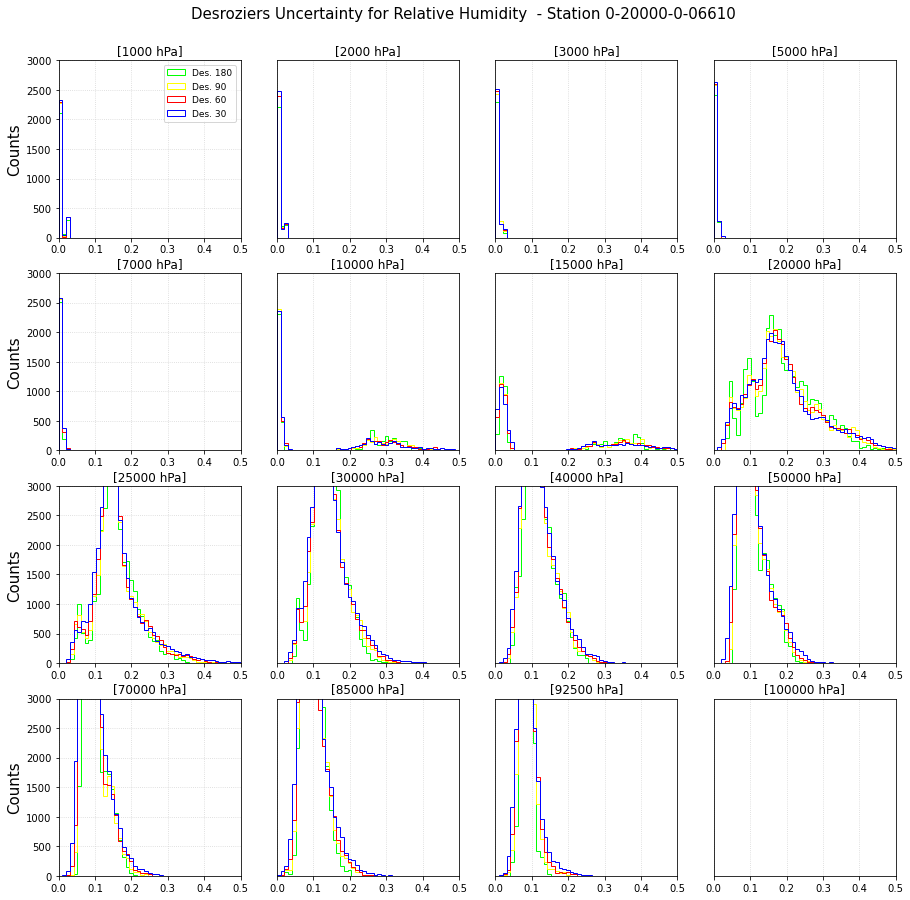

85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]
85  unique values:   [85]


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you 

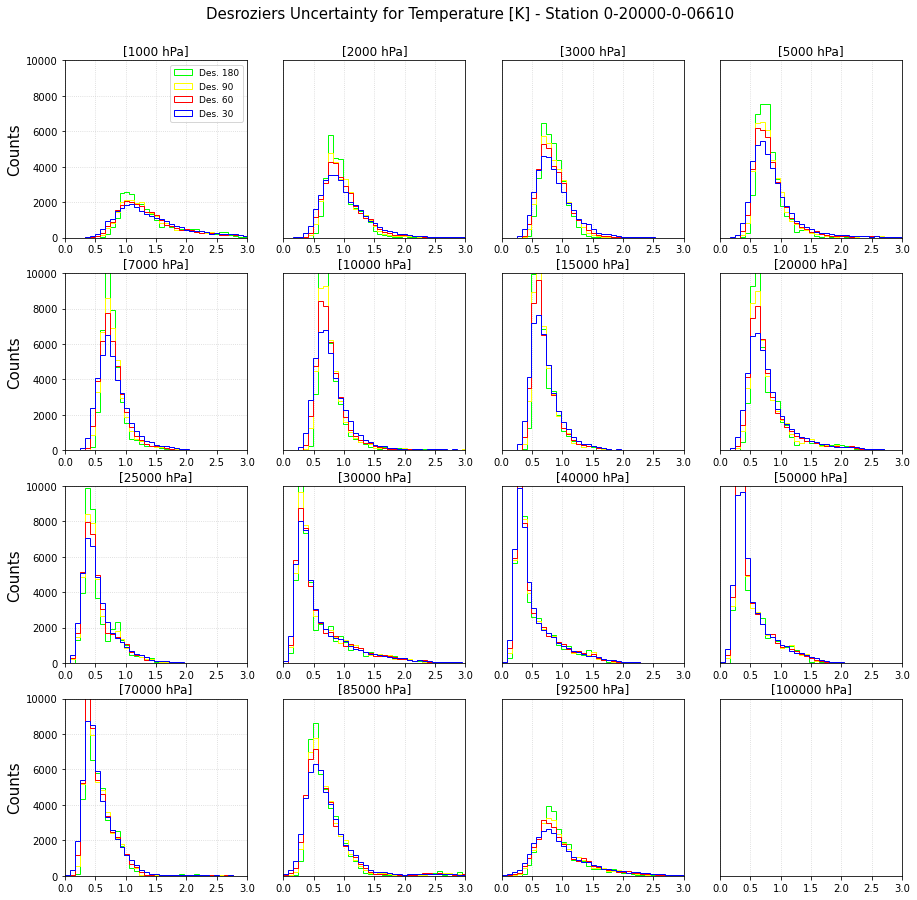

104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]
104  unique values:   [104]


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you 

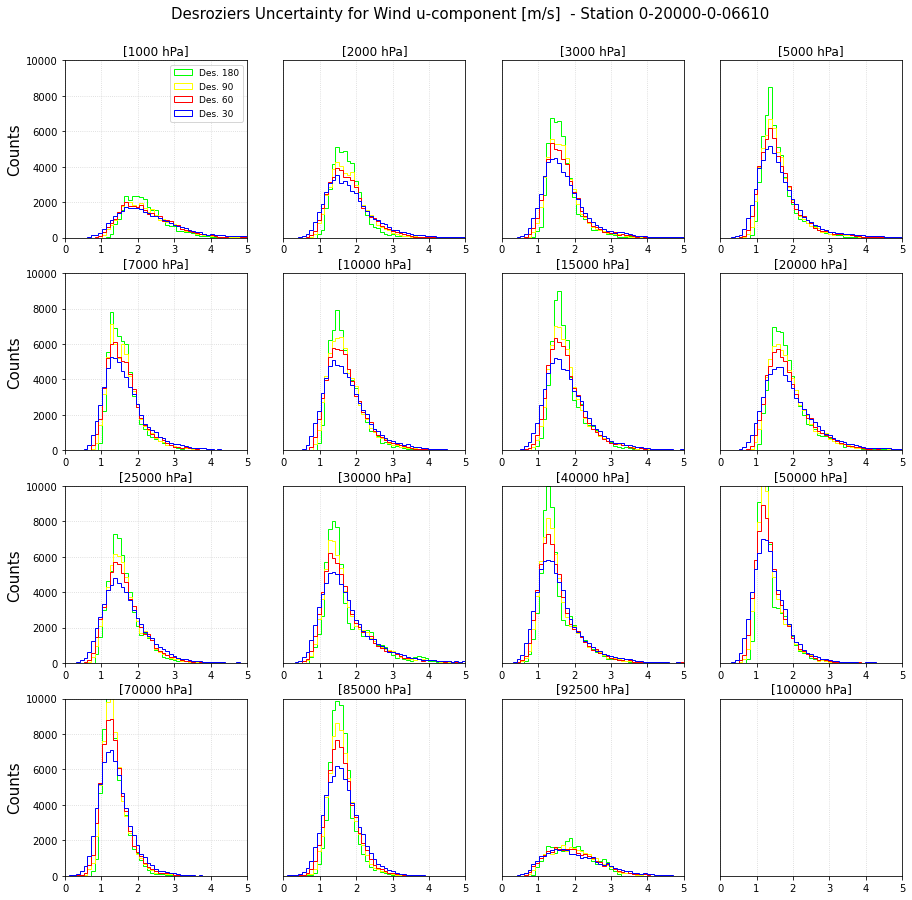

105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]
105  unique values:   [105]


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you 

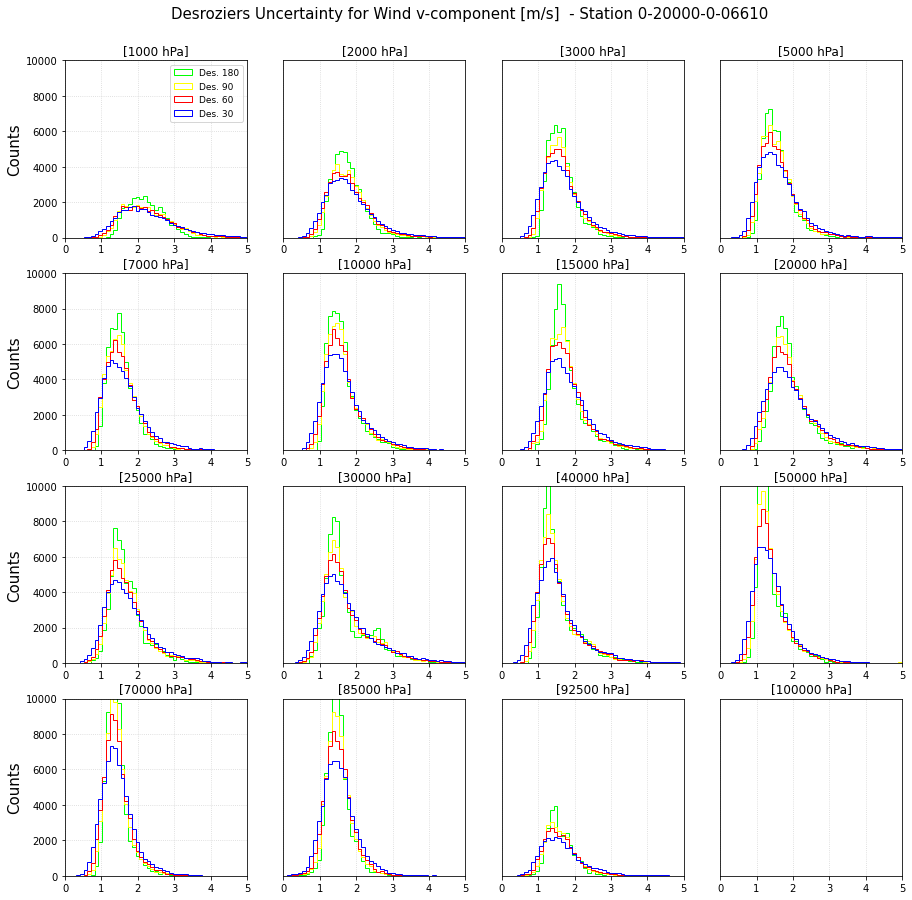

107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]
107  unique values:   [107]


/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6623: RuntimeWarning: All-NaN slice encountered
  xmin = min(xmin, np.nanmin(xi))
/opt/anaconda3/lib/python3.8/site-packages/matplotlib/axes/_axes.py:6624: RuntimeWarning: All-NaN slice encountered
  xmax = max(xmax, np.nanmax(xi))
<ipython-input-8-9352aecfa1cb>:204: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you need to call figure or subplots with the constrained_layout=True kwarg.
  plt.savefig('Plots/desroziers/' + STATION + '/desroziers_' + which_plot + '_' + str(v) + '_' + what + '_' + text + '_' + STATION + '.png' , dpi = 150)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Calling figure.constrained_layout, but figure not setup to do constrained layout.  You either called GridSpec without the fig keyword, you are using plt.subplot, or you 

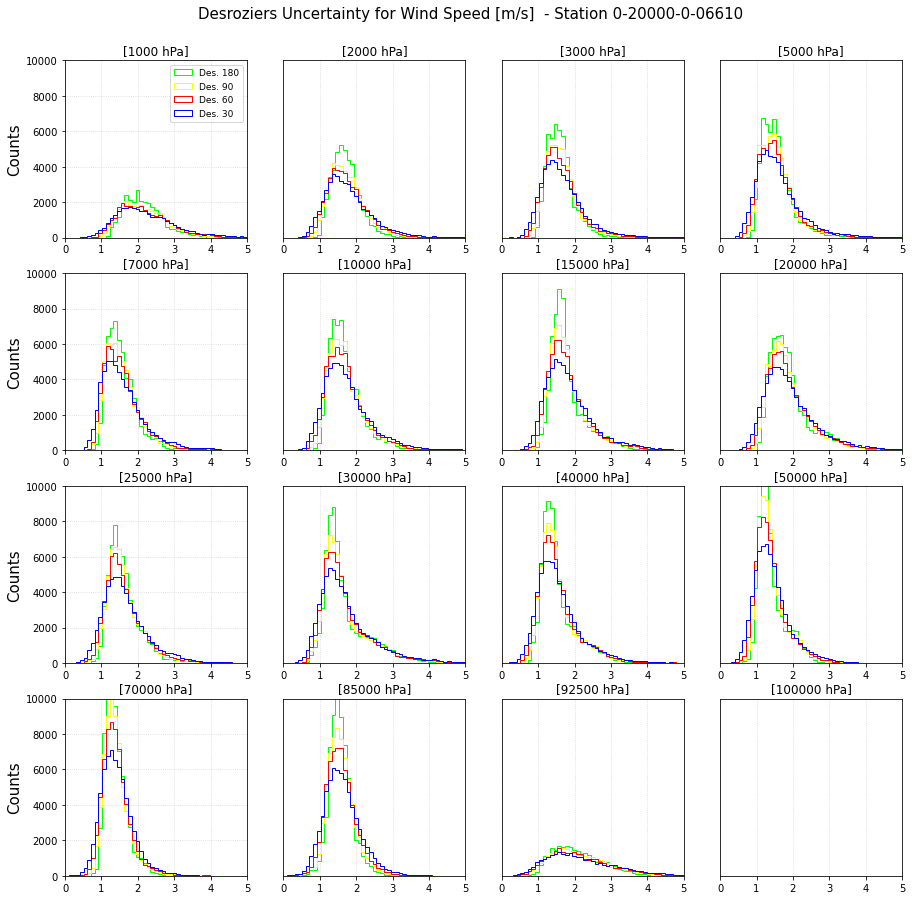

In [16]:
variables = [38,85,104,105,107]
plots = plot(df_in=res, station=STATION, vars = variables, what = 'dep', zoom = True , which_plot = 'histo' )

In [17]:
def plot_profile(df_in='', date='', station='', vars = [], zoom = False ):
    
    dic = { 85 : {'x':'Temperature [K]'       , 'y': 'Pressure [hPa]'} ,
            106 : {'x': 'Wind from Direction'  , 'y': 'Pressure [hPa]'},
            107 : {'x': 'Wind Speed [m/s] '    , 'y': 'Pressure [hPa]'},
         
            104 : {'x': 'Wind u-component [m/s] '    , 'y': 'Pressure [hPa]'},
            105 : {'x': 'Wind v-component [m/s] '    , 'y': 'Pressure [hPa]'},

          }
    
    std_plevs    = [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]
    std_plevs_h = list( np.array(std_plevs) / 100 )

    dt = (date - datetime(1900,1,1,0,0)).total_seconds()

    DATE = date.strftime('%Y%m%d%h%m')


    for v in vars:
        df = df_in[str(v)]
        
        print()
        """ Selecting the variable temperature """
        dt = 3399382800
        #print(df['date_time'][1213000:1213148])
        
        indices = np.where (df['date_time'][:]== dt)[0]
        #print(indices)
        #print(df['date_time'].values[-1])
        df = df.iloc[indices]
        #print(df)
        #print(df[['date_time','desroziers_30','z_coordinate']])
        temp, bias, press, adj = [], [], [], []
        des_30, des_60, des_90, des_180 = [], [], [], []
        des_30_p, des_30_m = [], []
        des_60_p, des_60_m = [], []
        des_90_p, des_90_m = [], []
        des_180_p, des_180_m = [], []

        for p in std_plevs:
            ind = np.where ( df['z_coordinate'] == p )[0]
            DF = df.iloc[ind]
            #print(df)
            if len(ind) > 0:

                t = DF['observation_value'].values[0]
                b = DF['biascorr@body'].values[0]
                d30 = DF['desroziers_30'].values[0]
                d60 = DF['desroziers_60'].values[0]
                d90 = DF['desroziers_90'].values[0]
                d180 = DF['desroziers_180'].values[0]

                if v != 85:
                    b = 0
                    
                if not np.isnan(t) and not np.isnan(b) and not np.isnan(d30):
                    temp.append(t )
                    bias.append(b)
                    des_30.append(d30)
                    des_60.append(d60)
                    des_90.append(d90)
                    des_180.append(d180)
                    
                    press.append(p/100)
                    a = t-b
                    adj.append(a)
                    des_30_m.append(a - d30/2)
                    des_30_p.append(a + d30/2)

                    des_60_m.append(a - d60/2)
                    des_60_p.append(a + d60/2)
                    
                    des_90_m.append(a - d90/2)
                    des_90_p.append(a + d90/2)
                    
                    des_180_m.append(a - d180/2)
                    des_180_p.append(a + d180/2)

        obs_all = df['observation_value'].values
        p_all = df['z_coordinate'].values/100
        
        fs = 20
        fig, ax1= plt.subplots(figsize=(12,10) )        

        fig.suptitle('Station ' + station + ' - Profile '  + DATE , y = 0.94, fontsize = fs)

        ax1.tick_params(axis='both', which='major', labelsize=12)
        ax1.tick_params(axis='both', which='minor', labelsize=8)
        ax1.set_yticks(std_plevs_h)
        w = ax1.invert_yaxis() 

        """ Adding errors band """
        #print(press, des_30_m, des_30_p)
        
     
        
        ax1.errorbar(adj, press , xerr = des_30  , label = 'Desroziers 30'  , color = 'blue' , alpha = 0.4 , lw = 10 , ls = 'none' )
        ax1.errorbar(adj, press , xerr = des_60  , label = 'Desroziers 60'  , color = 'lime' , alpha = 0.4 , lw = 8 , ls = 'none' )
        ax1.errorbar(adj, press , xerr = des_180 , label = 'Desroziers 180' , color = 'red'  , alpha = 0.4 , lw = 6 , ls = 'none' )

        
        ax1.set_ylabel( dic[v]['y'] , fontsize = fs )     
        ax1.set_xlabel( dic[v]['x'] , fontsize = fs )          

        #print(obs_all, p_all)
        #ax1.scatter(obs_all, p_all, color = 'gray' , label = 'All Observations' , s = 15)
        
        ax1.plot(temp, press, color = 'black'   , label = 'Observation'  , lw = 1)     
        ax1.scatter(temp, press, color = 'red'   , label = 'Observation'  , marker = 's' , s = 10)
        ax1.scatter(adj, press, color = 'orange' , label = 'Adjusted Obs.', marker = 's', s = 10)
        
        
        ax1.grid(ls =":" , color = "lightgray")
        ax1.legend(fontsize = fs)
        
        os.system('mkdir Plots')
        
        if v == 85 and zoom:
            ax1.set_xlim (190,250)
            plt.savefig('Plots/desroziers/Desrozier_profile_' + DATE + '_zoom_' + str(v) + '.png', dpi = 150 )
        else:
            plt.savefig('Plots/desroziers/Desrozier_profile_' + DATE + '_' + str(v) + '.png', dpi = 150 )

        plt.show()
        plt.close(9)
    
  

In [18]:
""" Convert to datetime in seconds adter 1900-01-01-00:00"""
t = datetime(2018,12,1,12,0)



#profile = plot_profile(df_in=res, date=t, station=STATION, vars = [85, 104,105,107], zoom = False )

In [19]:
def plot_countour_timeseries(res, var, window, station='', log = True):
    fs = 12
    a = res[str(var)]

    x   = a['date_time']
    x = np.array(x)/(3600*24*365.25) + 1900

    plev = a['z_coordinate']
    num = str(window)
    data = a['desroziers_' + num ]
    finite = np.isfinite(data) # or the interpolation does not like it 

    fig,ax = plt.subplots(figsize = (10,5))
    levels = np.linspace(0,2,50)
    levels = np.linspace(0,0.5,51)

    if var == 85:
        m=3
        levels = np.linspace(0,m,61)
        nums = [0.3*i for i in range(11) ]
        col = 'coolwarm'
        plt.xlim([1970.,2021.])

    elif var == 38:
        m = 0.3
        levels = np.linspace(0,m,31)
        nums = [0.03*i for i in range(11) ]
        col= 'cividis'
        plt.xlim([1970.,2021.])

        
    elif var in [104,105,107]:
        m=5
        levels = np.linspace(0,m,51)
        nums = [0.5*i for i in range(11) ]
        col = 'GnBu_r'
        plt.xlim([1970.,2021.])

    '''
    contours = ax.tricontourf(x[finite], plev[finite]/100, data[finite], levels = levels, cmap = 'viridis', 
                              extend = 'min',
                               vmin = vmin, vmax = vmax)
    '''
    contours = ax.tricontourf(x[finite], plev[finite]/100, data[finite], levels = levels, cmap = col, 
                              extend = 'min')
        
    plt.gca().invert_yaxis()
    log_lab = 'Log'
    if log:
        ax.set_yscale('log')
        plevels_toshow = [10, 20, 30, 50, 70, 100, 150, 300, 500, 700, 850, 1000]

    else:
        log_lab = ''
        plevels_toshow = [10, 50, 70, 100, 150, 300, 500, 700, 850, 925, 1000]


    # [1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 70000, 85000, 92500, 100000]:

    ax.set_yticks( plevels_toshow ) 
    ax.set_yticklabels( plevels_toshow )

    plt.title('Desroziers Uncertainty [' + num + ' days av.]', fontsize = fs, y = 1.03)

    cbar = fig.colorbar(contours)
    

        
    cbar.set_ticks(nums)
    
    #cbar = fig.colorbar(contours )

    cbar.set_label(dic[var]['x'])
    #cbar.ax.set_yticks( list(num_tcks) )
    #cbar.ax.set_yticklabels( list(num_tcks) )
    plt.savefig('Plots/desroziers/Desrozier_contour_error_' + num + '_days_' + str(var) + '_' + log_lab + '.png', dpi = 150 )
        
    plt.show()
    if not os.path.isdir('Plots/desroziers'):
        os.system('mkdir Plots/desroziers/')


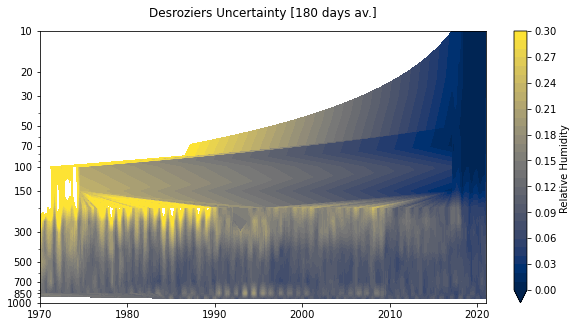

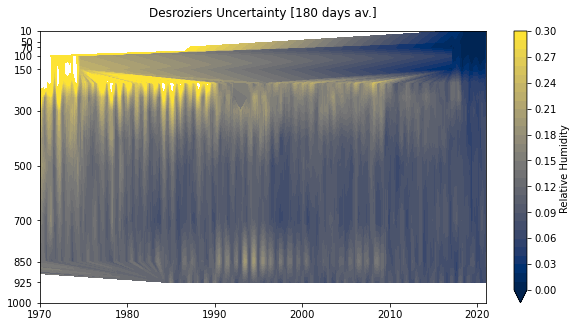

In [20]:
all_level_series= plot_countour_timeseries(res, 38, 180, station=STATION )
all_level_series= plot_countour_timeseries(res, 38, 180, station=STATION , log=False)

In [ ]:
all_level_series= plot_countour_timeseries(res, 107, 180, station=STATION )
all_level_series= plot_countour_timeseries(res, 107, 180, station=STATION , log=False)

In [ ]:
all_level_series= plot_countour_timeseries(res, 85, 180, station=STATION )
all_level_series= plot_countour_timeseries(res, 85, 180, station=STATION , log=False)